In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.ticker import FormatStrFormatter
import matplotlib.gridspec as gridspec
import seaborn as sns

from gwbird import detectors
from gwbird.skymap import Basis, Skymaps
from gwbird import pls
from gwbird.overlap import Response
from gwbird.nell import AngularResponse, Sensitivity_ell
from gwbird import nell

%config InlineBackend.figure_format = 'retina'

sns.set_palette("husl")
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['font.family'] = 'serif'

# Antenna Pattern maps

Antenna pattern function: detector response to an incoming GW signal

Parameters:

- det1, det2: str or list of str
    The name of the detector(s) to consider.
    The names must be in the list of detectors available.
    The list of available detectors can be obtained by calling the function detectors.available_detectors().
    The names of the detectors are case sensitive.
    If you want to provide a custom detector, you can provide the following information in a list:

    H = [c, xA, xB, l, name]

    - c: array_like of length 3 (Position of the detector in the Earth-centered frame in meters)
    - xA: array_like of length 3 (Unit vector pointing towards the detector in the Earth-centered frame)
    - xB: array_like of length 3 (Unit vector pointing towards the detector in the Earth-centered frame)
    - l: float (Length of the arm in meters)
    - name: str (Name of the detector)

- f: frequency array

- psi: polarization angle in [0, pi]

- pol: polarization type: 't', 'v', 's', 'I', 'V'

- nside: int, optional\
    The nside parameter for the healpy function. Default is 32.

- shift_angle: float, optional\
    The separation angle between ET L Sardinia - ET L The Netherlands. Default is None.

Returns:
overlap_map: overlap map, array of shape (npix,)


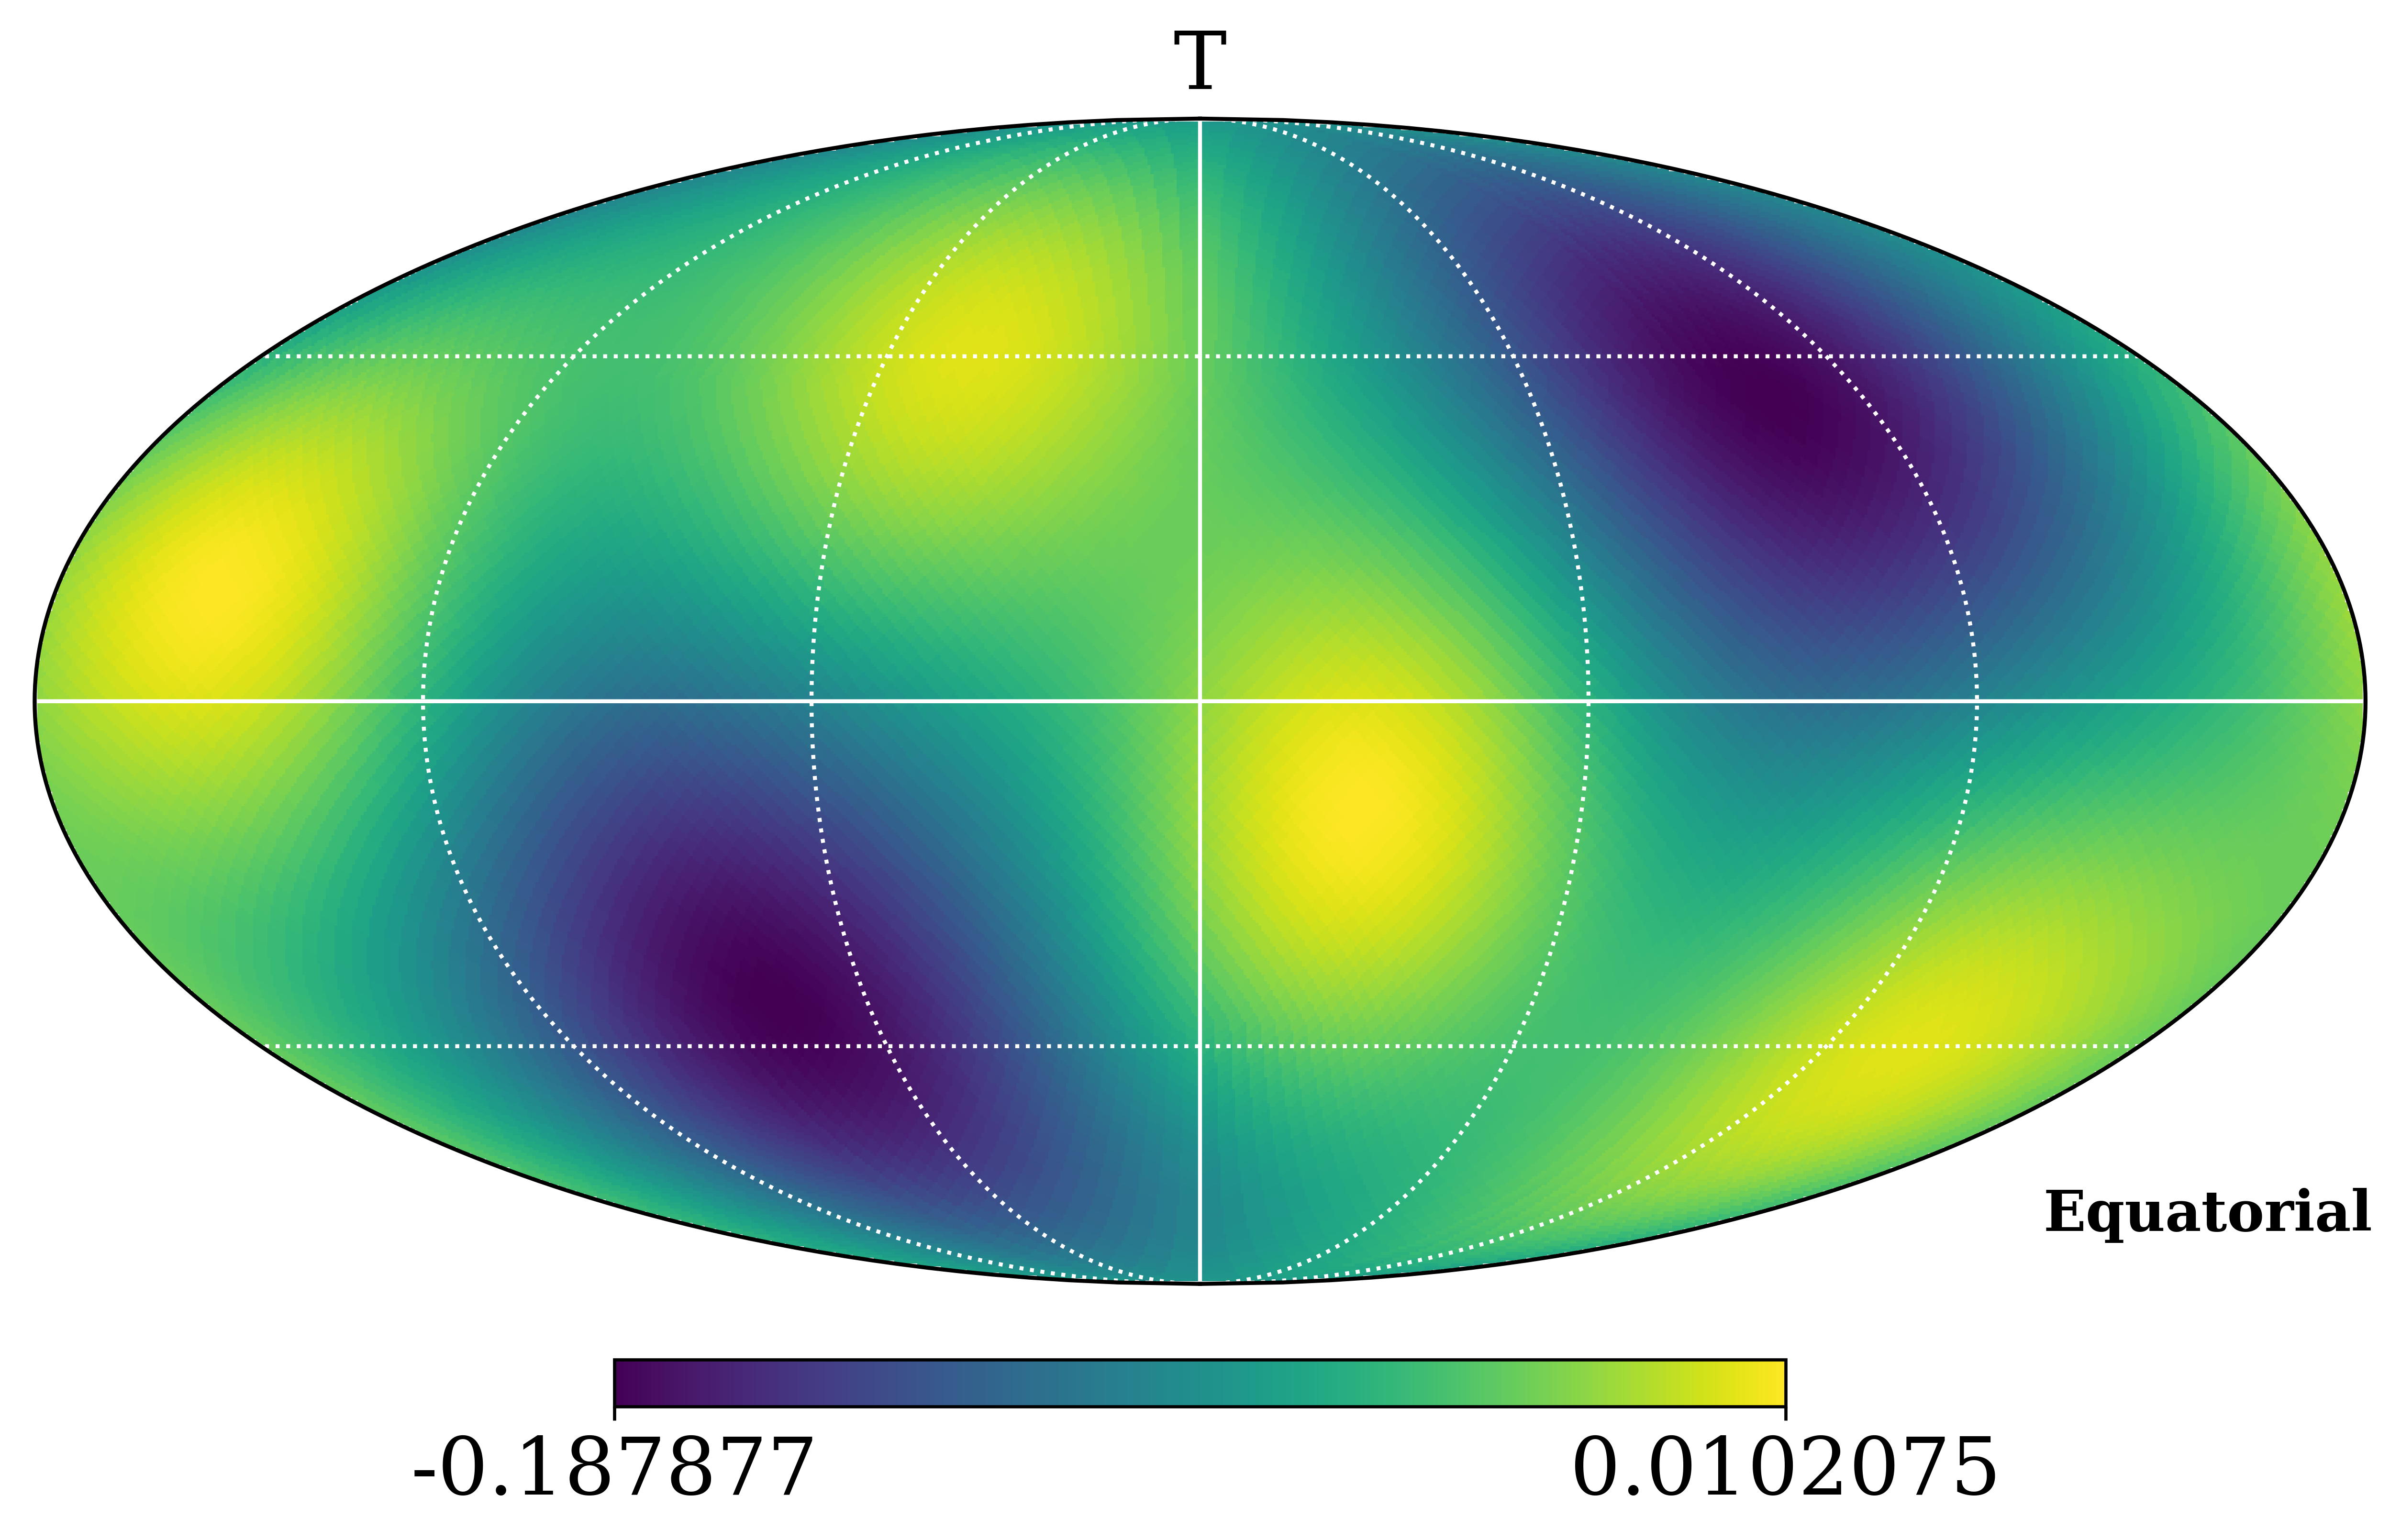

In [12]:
mapHL = Skymaps.AntennaPattern('LIGO H', 'LIGO L', 1e-2, 0, 't')

# Overlap reduction function

## Ground Based Detectors


Calculate the overlap response between two detectors.

R = Response.overlap(det1, det2, f, psi, pol, shift_angle=False)

Parameters:
- det1, det2: str or list of str
    The name of the detector(s) to consider.
    The names must be in the list of detectors available in the response module.
    The list of available detectors can be obtained by calling the function detectors.available_detectors().
    The names of the detectors are case sensitive.
    If you want to provide a custom detector, you can provide the following information in a list:

    H = [c, xA, xB, l, name]

    - c: array_like of length 3 (Position of the detector in the Earth-centered frame in meters)
    - xA: array_like of length 3 (Unit vector pointing towards the detector in the Earth-centered frame)
    - xB: array_like of length 3 (Unit vector pointing towards the detector in the Earth-centered frame)
    - l: float (Length of the arm in meters)
    - name: str (Name of the detector)

- f: array_like (Frequency in Hz)
- psi: float (Polarization angle in radians)
- pol: str (Polarization of the signal, 't' for tensor, 'v' for vector, 's' for scalar, 'I' for tensor intensity stokes parameter, 'V' for tensor circular polarization stokes parameter )

Optional parameters:
- shift_angle: bool or float (Shift the angle of the response if considering ET 2L in radians)



In [13]:
print(detectors.available_detectors())

f = np.logspace(0, 3, 1000)
R_LIGO = Response.overlap('LIGO H', 'LIGO L', f, 0, 't', None)
R_ET = Response.overlap('ET X', 'ET Y', f, 0, 't', None)
R_ET2L0 = Response.overlap('ET L1', 'ET L2', f, 0, 't', shift_angle=0)
R_ET2L45 = Response.overlap('ET L1', 'ET L2', f, 0, 't', shift_angle=np.pi/4)


['LIGO H', 'LIGO L', 'Virgo', 'KAGRA', 'CE', 'ET X', 'ET Y', 'ET Z', 'ET L1', 'ET L2', 'LISA X', 'LISA Y', 'LISA Z']


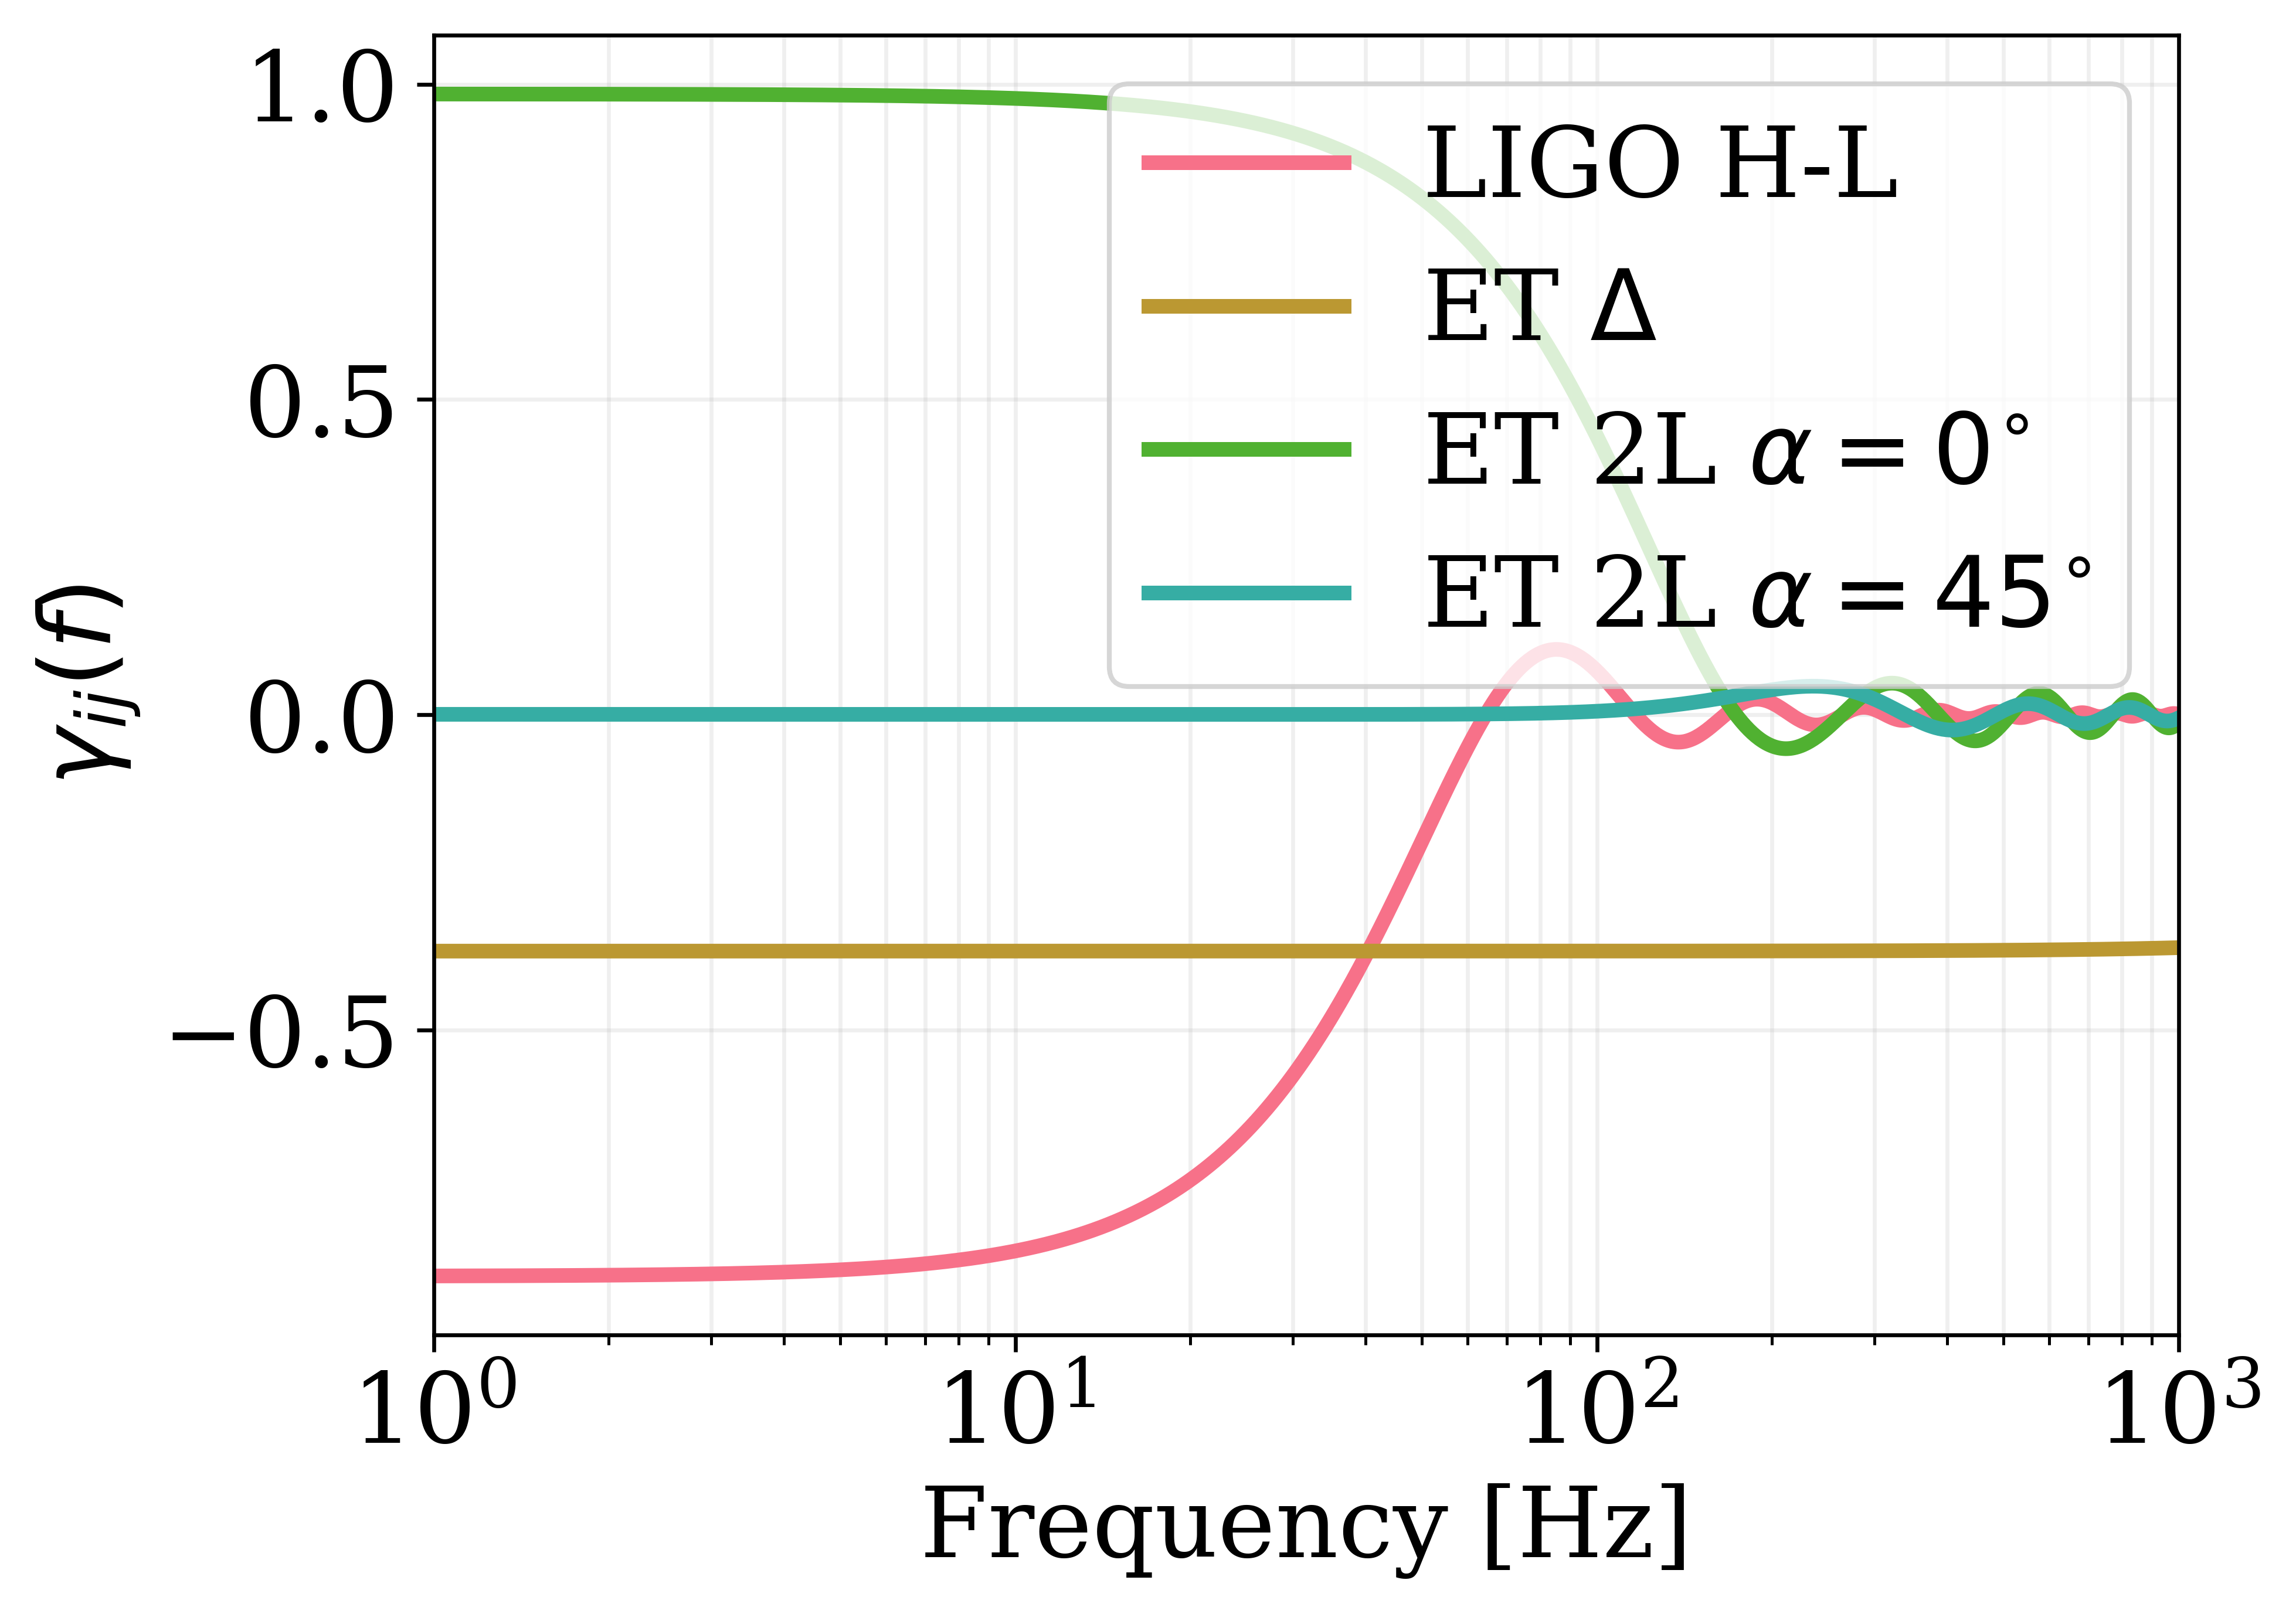

In [99]:
plt.plot(f, R_LIGO, label='LIGO H-L')
plt.plot(f, R_ET, label=r'ET $\Delta$')
plt.plot(f, R_ET2L0, label=r'ET 2L $\alpha=0^{\circ}$')
plt.plot(f, R_ET2L45, label=r'ET 2L $\alpha=45^{\circ}$')
plt.xlabel('Frequency [Hz]')
plt.xscale('log')
plt.ylabel(r'$\gamma_{ij}(f)$')
plt.xlim(f.min(), f.max())
plt.grid(which='both', alpha=0.2) 
plt.legend()  


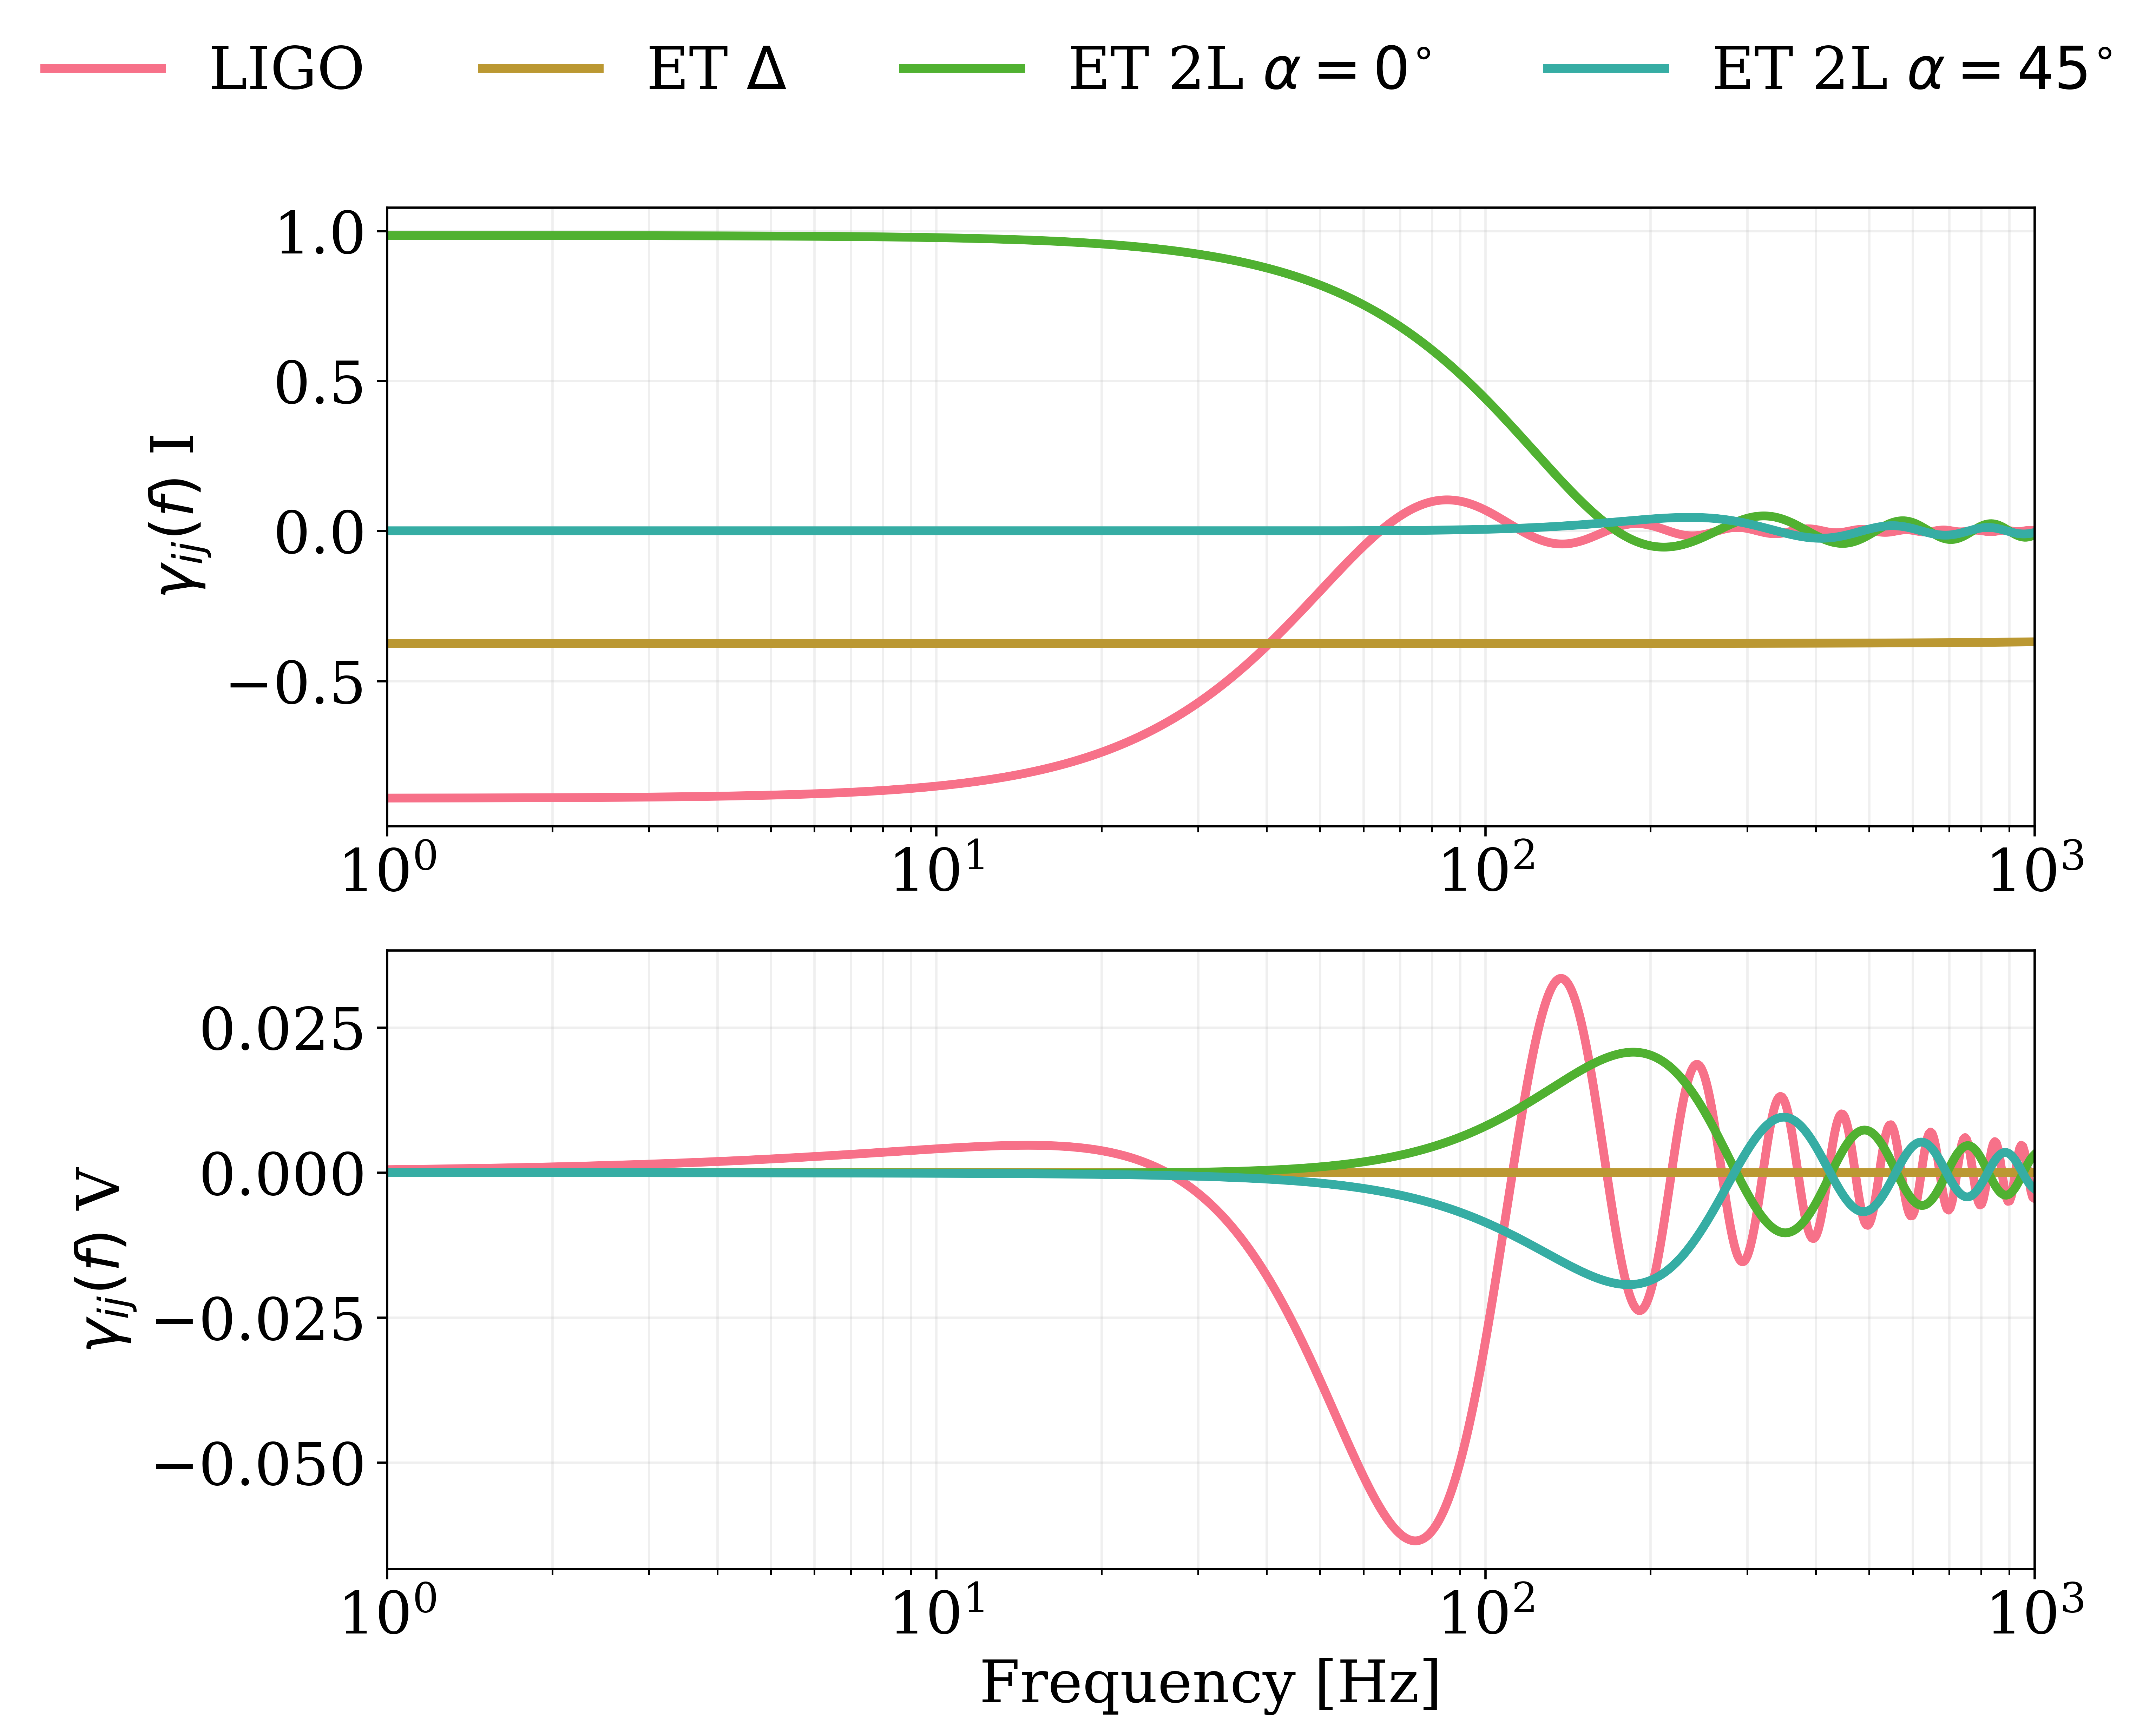

In [14]:
# example of the overlap function for the I and V stokes parameter

R_LIGO_I = Response.overlap('LIGO H', 'LIGO L', f, 0, 'I', None)
R_LIGO_V = Response.overlap('LIGO H', 'LIGO L', f, 0, 'V', None)
R_ET_I    = Response.overlap('ET X', 'ET Y', f, 0, 'I', None)
R_ET_V    = Response.overlap('ET X', 'ET Y', f, 0, 'V', None)
R_ET2L0_I = Response.overlap('ET L1', 'ET L2', f, 0, 'I', shift_angle=0)
R_ET2L0_V = Response.overlap('ET L1', 'ET L2', f, 0, 'V', shift_angle=0)
R_ET2L45_I = Response.overlap('ET L1', 'ET L2', f, 0, 'I', shift_angle=np.pi/4)
R_ET2L45_V = Response.overlap('ET L1', 'ET L2', f, 0, 'V', shift_angle=np.pi/4)

plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)

plt.plot(f, R_LIGO_I, label='LIGO')
plt.plot(f, R_ET_I, label=r'ET $\Delta$')
plt.plot(f, R_ET2L0_I, label=r'ET 2L $\alpha=0^{\circ}$')
plt.plot(f, R_ET2L45_I, label=r'ET 2L $\alpha=45^{\circ}$')
plt.xscale('log')
plt.ylabel(r'$\gamma_{ij}(f)$ I')
plt.xlim(f.min(), f.max())
plt.grid(which='both', alpha=0.2)

plt.subplot(2, 1, 2)
plt.plot(f, R_LIGO_V)#, label='LIGO')
plt.plot(f, R_ET_V)#, label=r'ET $\Delta$')
plt.plot(f, R_ET2L0_V)#, label=r'ET 2L $\alpha=0^{\circ}$')
plt.plot(f, R_ET2L45_V)#, label=r'ET 2L $\alpha=45^{\circ}$')
plt.xlabel('Frequency [Hz]')
plt.xscale('log')
plt.ylabel(r'$\gamma_{ij}(f)$ V')
plt.xlim(f.min(), f.max())
plt.grid(which='both', alpha=0.2)


# Ottieni le linee e le etichette delle legende
lines_labels = [ax.get_legend_handles_labels() for ax in plt.gcf().axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

# Filtra le etichette per mostrare solo le intensità
intensity_labels = ['LIGO', r'ET $\Delta$', r'ET 2L $\alpha=0^{\circ}$', r'ET 2L $\alpha=45^{\circ}$']
filtered_lines_labels = [(line, label) for line, label in zip(lines, labels) if label in intensity_labels]

# Verifica se ci sono etichette filtrate
if filtered_lines_labels:
    lines, labels = zip(*filtered_lines_labels)
else:
    lines, labels = [], []

# Posiziona la legenda in alto fuori dal plot in orizzontale
if lines and labels:
    plt.figlegend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=4, frameon=False)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## LISA

For triangular detector, like ET and LISA, it is available to consider their combination in the AET basis. 

You can type 'ET' or 'LISA' + space + 'A', 'E', 'T'.

Invalid combination of channels are properly handled. 

* Note: we do not adopt the convention by which $\gamma_{ij}$ is normalized by $1/4\pi$ for LISA but we normalize it as all the other detectors to $5/8\pi$

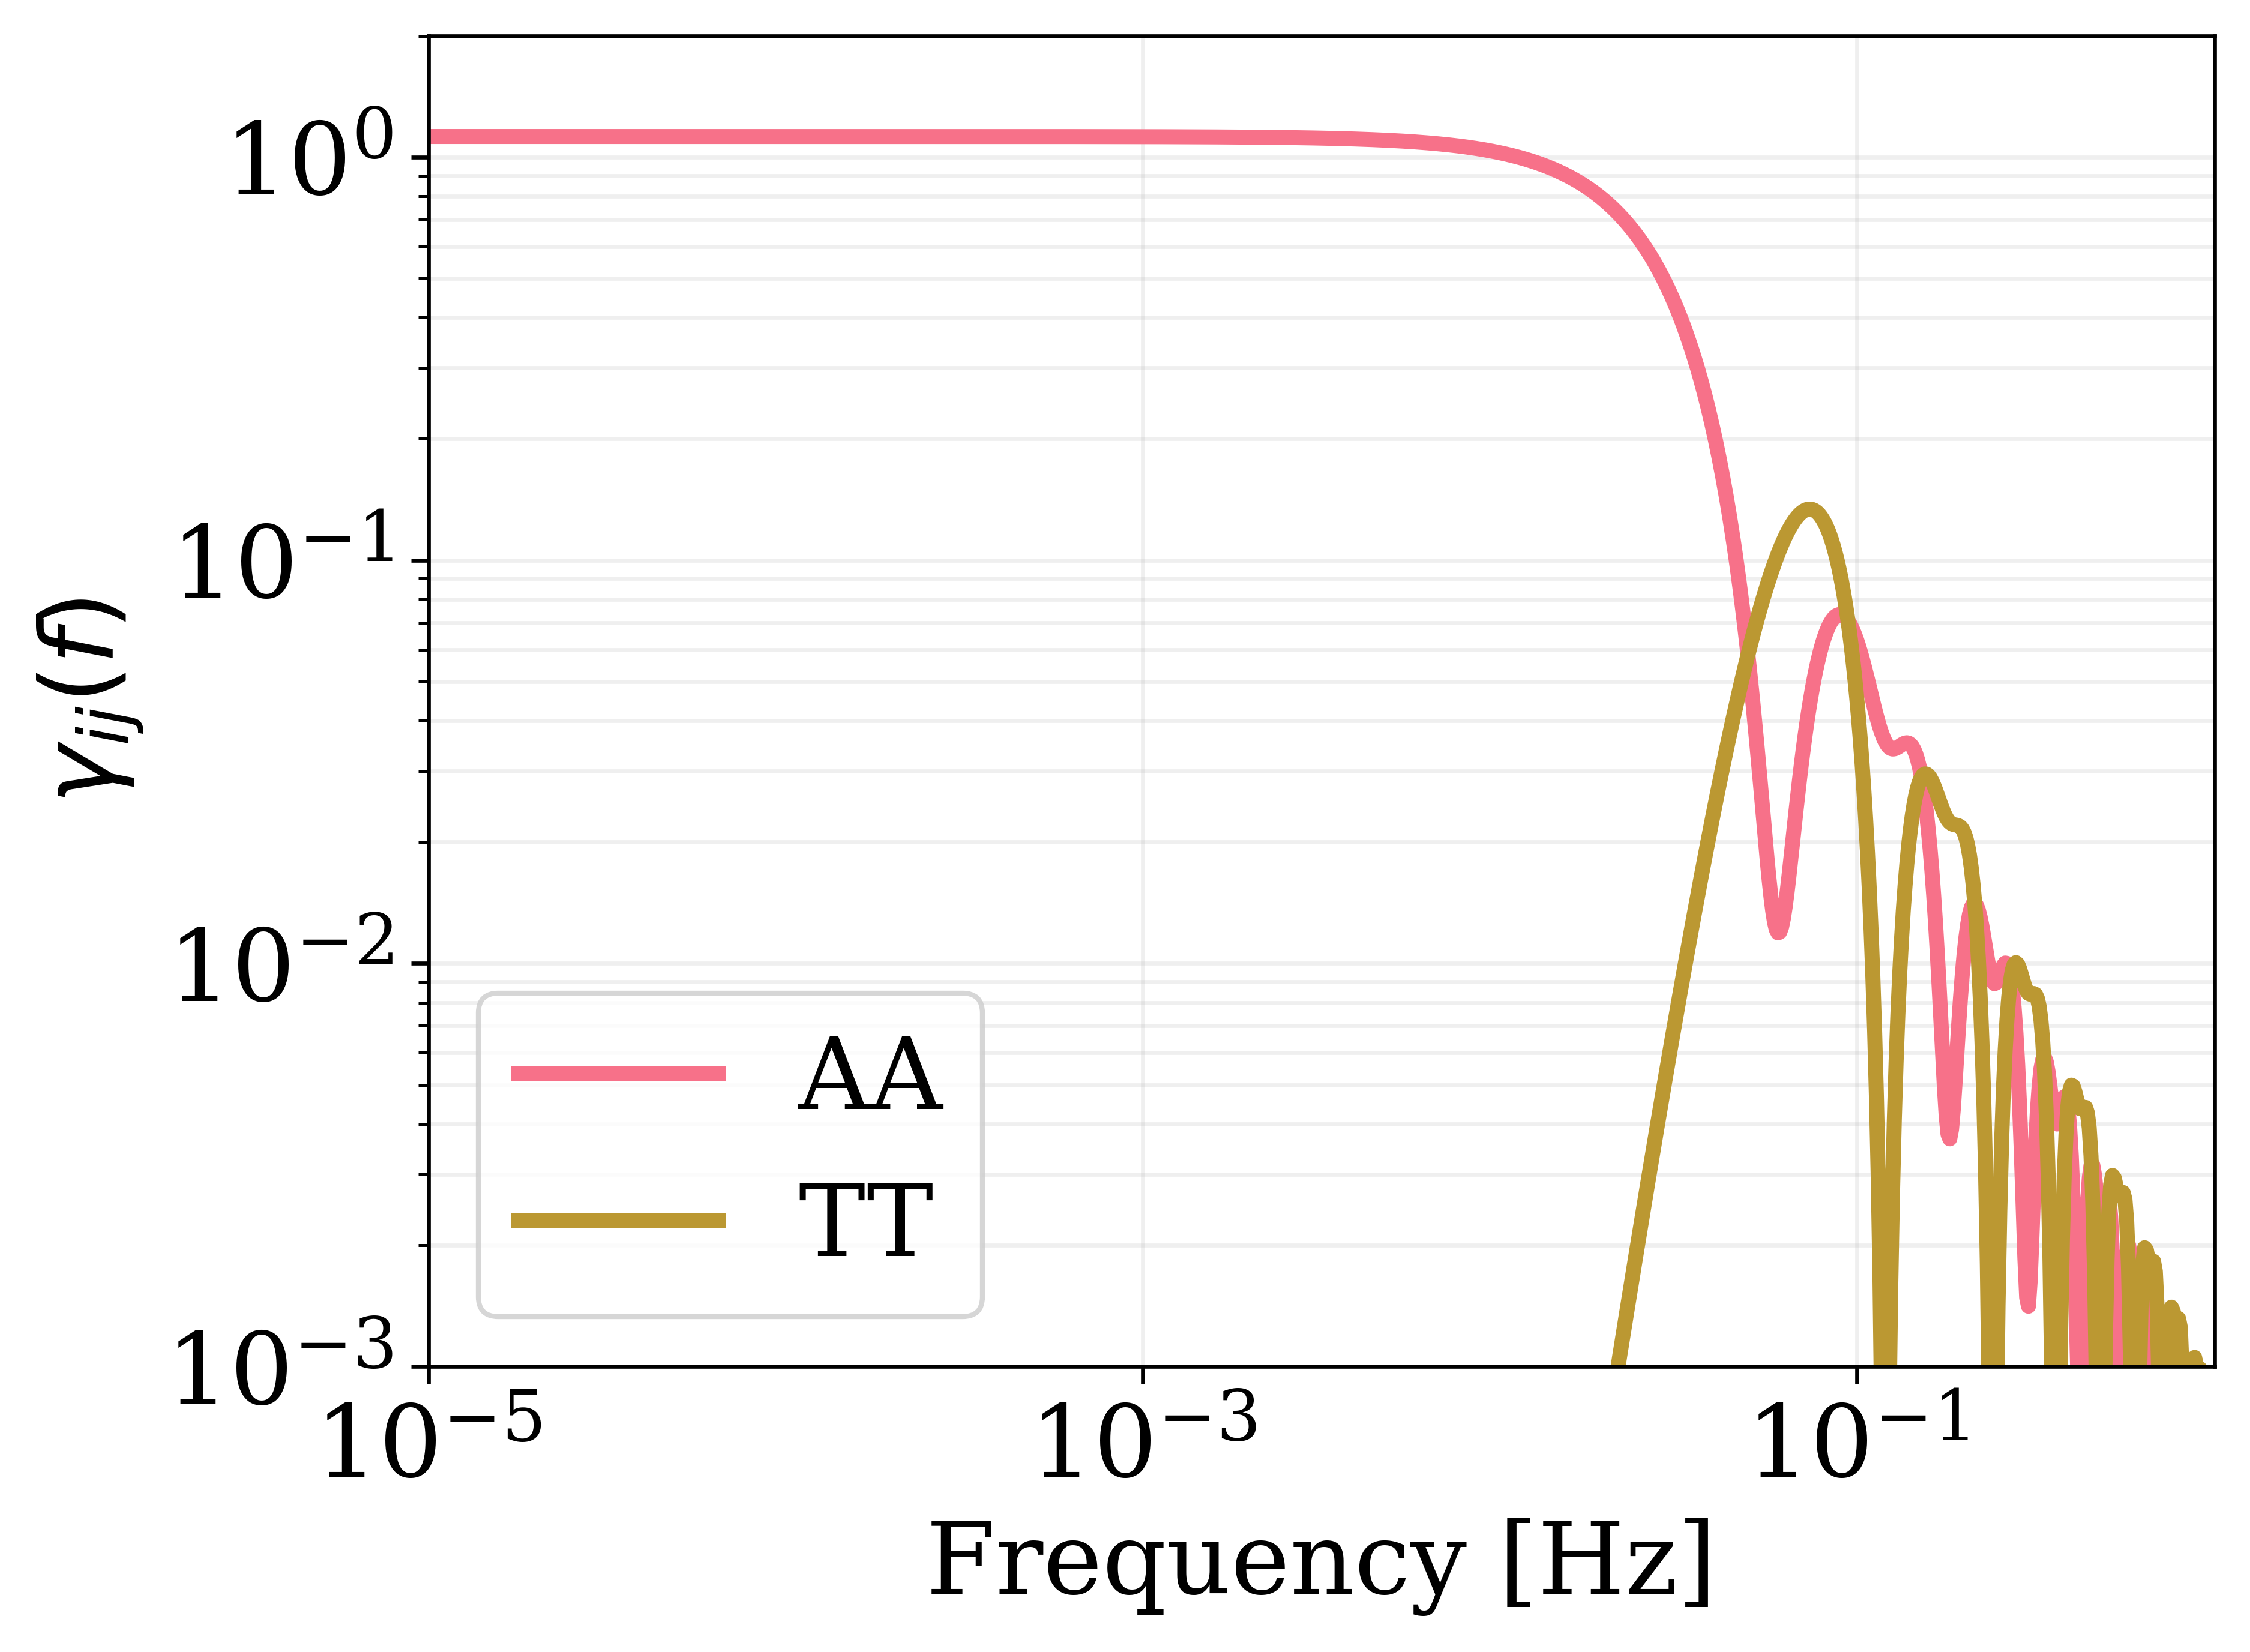

In [15]:
f_lisa = np.logspace(-5, 0, 1000)
R_AA = Response.overlap('LISA A', 'LISA A', f_lisa, 0, 't')
R_TT = Response.overlap('LISA T', 'LISA T', f_lisa, 0, 't')

plt.figure()
plt.plot(f_lisa, R_AA, label='AA')
plt.plot(f_lisa, R_TT, label='TT')
plt.xlabel('Frequency [Hz]')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$\gamma_{ij}(f)$')
plt.xlim(f_lisa.min(), f_lisa.max())
plt.ylim(1e-3, 2)
plt.grid(which='both', alpha=0.2)
plt.legend()

# Pulsar Timing Array

2025-03-07 16:29:03.165 | DEBUG    | pint.models.binary_ddk:validate:210 - Validating DDK model in ECL coordinates


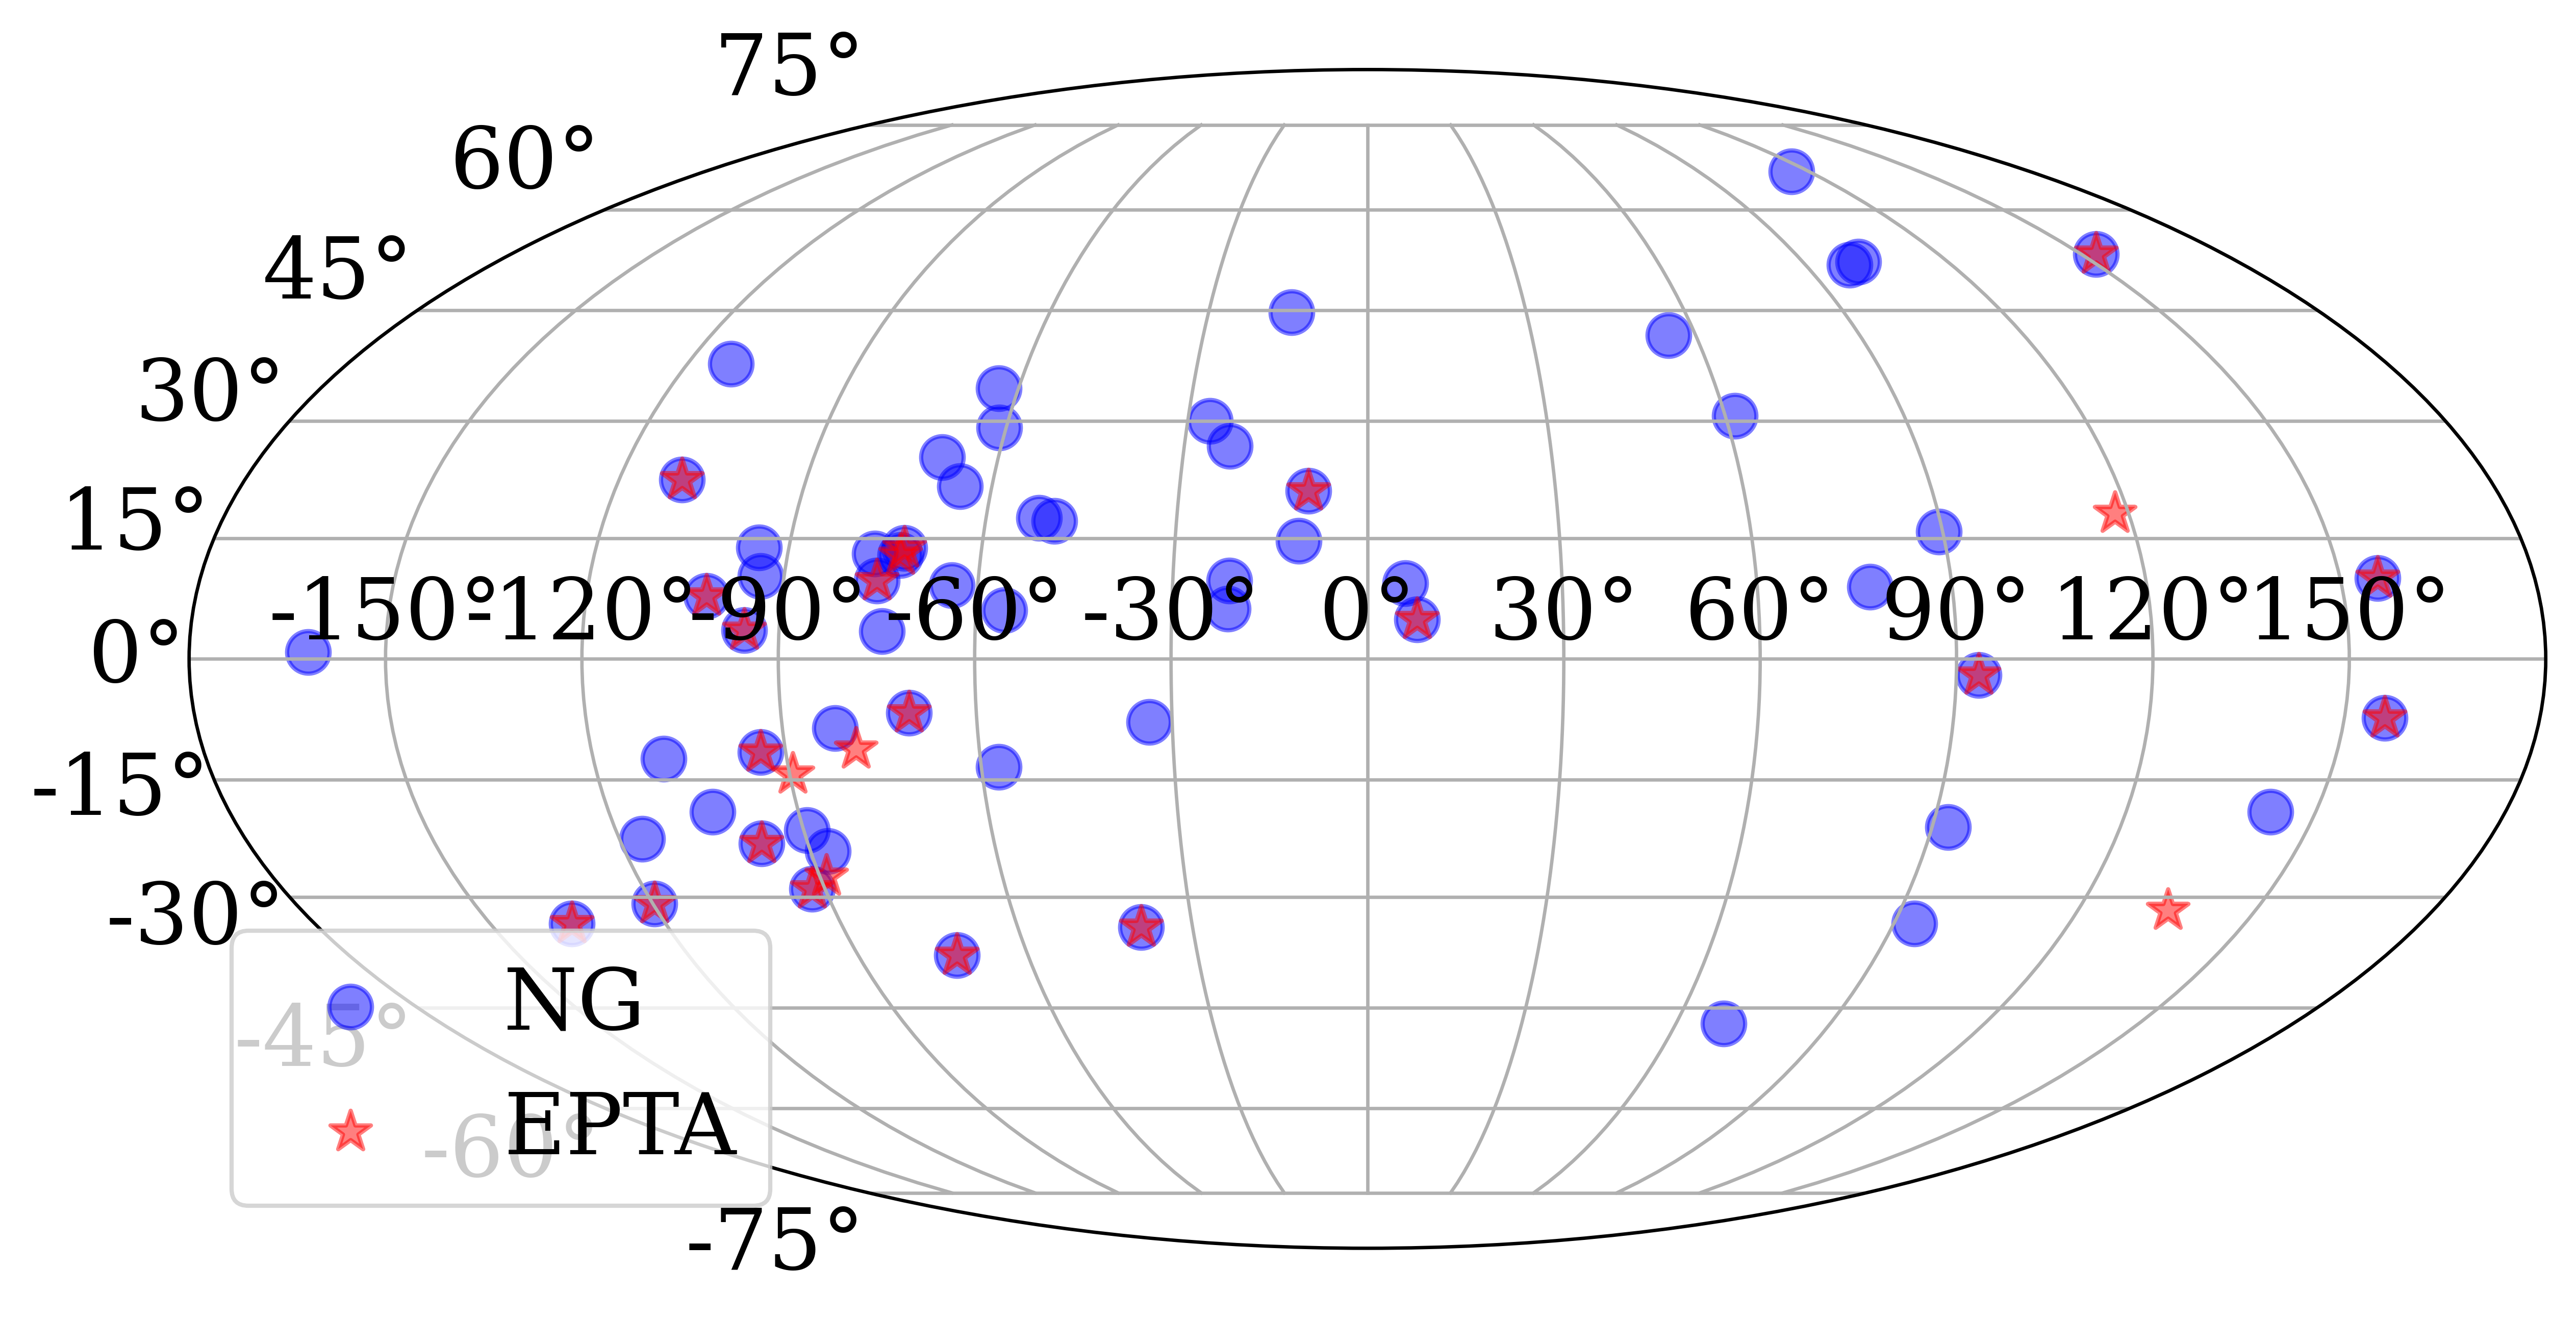

In [39]:
# check the normalization of the overlap function   

f = np.logspace(-9, -7, 100)

p_EPTA, _, _ = detectors.get_EPTA_pulsars()
_, p_NG, _ = detectors.get_NANOGrav_pulsars()
theta_EPTA = np.arccos(p_EPTA[:,2])
phi_EPTA = np.arctan2(p_EPTA[:,1], p_EPTA[:,0])
theta_NG = np.arccos(p_NG[:,2])
phi_NG = np.arctan2(p_NG[:,1], p_NG[:,0])

# Conversione in ascensione retta (RA) e declinazione (Dec)
ra_EPTA = np.degrees(phi_EPTA)  # Ascensione retta in gradi
dec_EPTA = 90 - np.degrees(theta_EPTA)  # Declinazione in gradi
ra_NG = np.degrees(phi_NG)  # Ascensione retta in gradi
dec_NG = 90 - np.degrees(theta_NG)  # Declinazione in gradi

ra_EPTA = np.radians(ra_EPTA)
dec_EPTA = np.radians(dec_EPTA)
ra_NG = np.radians(ra_NG)
dec_NG = np.radians(dec_NG)


plt.figure(figsize=(10, 5))
plt.subplot(111, projection='mollweide')
plt.grid(True)
plt.scatter(ra_NG, dec_NG, s=100, c='b', alpha=0.5, marker='o', label='NG')
plt.scatter(ra_EPTA, dec_EPTA, s=100, c='r', alpha=0.5, marker='*', label='EPTA')

plt.legend()
plt.show()

#  The GWB energy density sensitivity spectrum :
## Power law integrated sensitivity curve


## Detectors


Evaluate the sensitivity of a couple of detector to a GWB signal.

sens = pls.PLS(det1, det2, f, fref, pol, snr, Tobs, beta_min, beta_max, psi, shift_angle, fI=None, PnI=None, fJ=None, PnJ=None)

Parameters:

- det1, det2: str or list of str
    The name of the detector(s) to consider.
    The names must be in the list of detectors available in the response module.
    The list of available detectors can be obtained by calling the function detectors.available_detectors().
    The names of the detectors are case sensitive.
    If you want to provide a custom detector, you can provide the following information in a list:

    H = [c, xA, xB, l, name]

    - c: array_like of length 3 (Position of the detector in the Earth-centered frame in meters)
    - xA: array_like of length 3 (Unit vector pointing towards the detector in the Earth-centered frame)
    - xB: array_like of length 3 (Unit vector pointing towards the detector in the Earth-centered frame)
    - l: float (Length of the arm in meters)
    - name: str (Name of the detector)

- f = array_like (Frequency in Hz)
- fref = float (Reference frequency in Hz)
- pol = str (Polarization of the signal, 't' for tensor, 'v' for vector, 's' for scalar, 'I' for tensor intensity stokes parameter, 'V' for tensor circular polarization stokes parameter )
- snr = float (Signal-to-noise ratio threshold)
- Tobs = float (Observation time in years)
- psi = float (Polarization angle in radians)


Optional parameters:
- shift_angle = bool or float (Shift the angle of the response if considering ET 2L in radians)
- fI = bool or array_like (Frequency in Hz for the detector I)
- PnI = bool or array_like (Power spectral density for the detector I)
- fJ = bool or array_like (Frequency in Hz for the detector J)
- PnJ = bool or array_like (Power spectral density for the detector J)




## Pulsars


Compute the power law sensitivity curve for a pulsars catalog

If you want to consider EPTA:

pls_NANOGrav = pls.PLS_PTA_EPTA(f_PTA, snr, Tobs_PTA, pol, psi)

If you want to consider NANOGrav:

pls_NANOGrav = pls.PLS_PTA_NANOGrav(f_PTA, snr, Tobs_PTA, pol, psi)



Parameters:
- f: array (frequency array)
- snr: float (signal to noise ratio threshold)
- Tobs: float (observation time in years)
- pol: str (Polarization of the signal, 't' for tensor, 'v' for vector, 's' for scalar, 'I' for intensity, 'V' for circular)
- psi: float (Polarization angle in radians)

Returns:
- pls: array [shape: len(f)] (power law sensitivity curve  (h^2 \Omega_{GW}(f))) 



2025-03-07 16:36:04.788 | DEBUG    | pint.models.binary_ddk:validate:210 - Validating DDK model in ECL coordinates


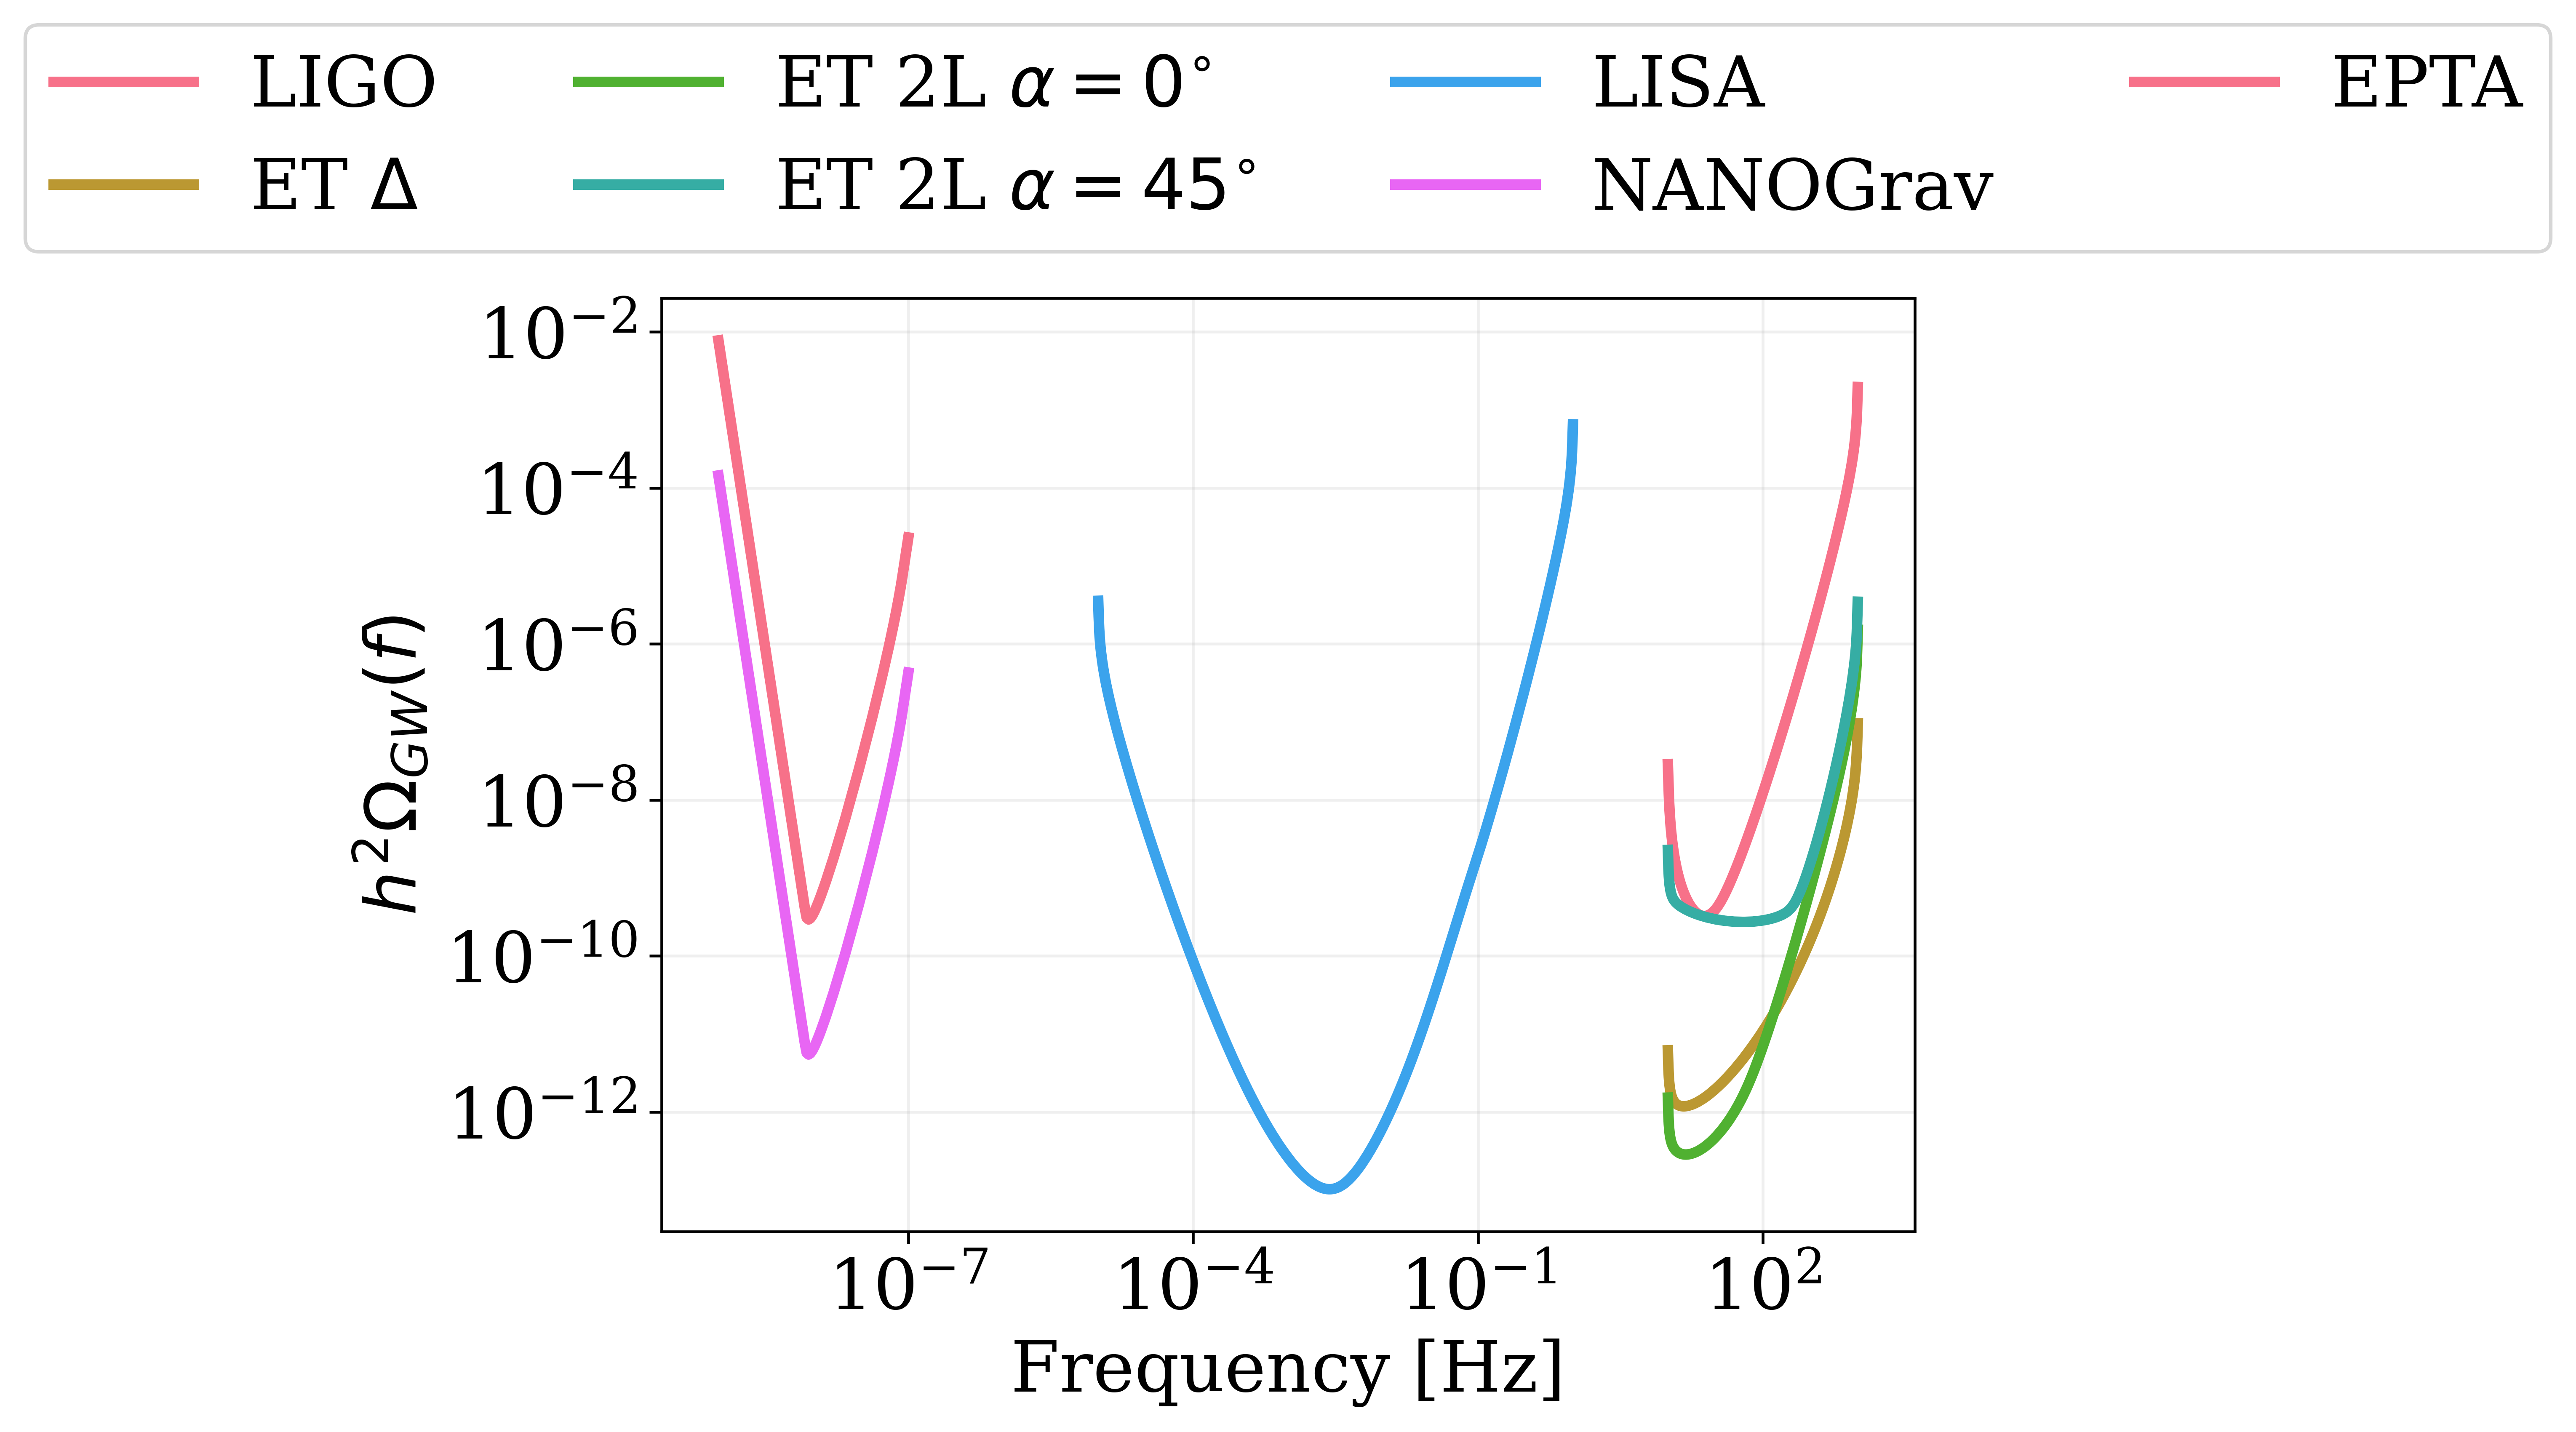

In [41]:
f = np.logspace(1, 3, 1000)
f_LISA = np.logspace(-5, 0, 1000)
f_PTA = np.logspace(-9, -7, 100)


fref = 25
fref_LISA = 1e-2
snr = 1
snr_LISA = 10
Tobs = 1
Tobs_LISA = 3
psi = 0
Tobs_PTA = 15

pls_LIGO = pls.PLS('LIGO H', 'LIGO L', f, fref, 't', snr, Tobs, psi)
pls_ET = pls.PLS('ET X', 'ET Y', f, fref, 't', snr, Tobs, psi)
pls_ET2L0 = pls.PLS('ET L1', 'ET L2', f, fref, 't', snr, Tobs, psi, 0)
pls_ET2L45 = pls.PLS('ET L1', 'ET L2', f, fref, 't', snr, Tobs, psi, np.pi/4)
pls_LISA = pls.PLS('LISA', 'Network', f_LISA, fref_LISA, 't', snr_LISA, Tobs_LISA, psi)
pls_EPTA = pls.PLS_PTA_EPTA(f_PTA, snr, Tobs_PTA, 't', psi)
pls_NANOGrav = pls.PLS_PTA_NANOGrav(f_PTA, snr, Tobs_PTA, 't', psi)

plt.plot(f, pls_LIGO, label='LIGO')
plt.plot(f, pls_ET, label=r'ET $\Delta$')
plt.plot(f, pls_ET2L0, label=r'ET 2L $\alpha=0^{\circ}$')
plt.plot(f, pls_ET2L45, label=r'ET 2L $\alpha=45^{\circ}$')
plt.plot(f_LISA, pls_LISA, label='LISA')
plt.plot(f_PTA, pls_NANOGrav, label='NANOGrav')
plt.plot(f_PTA, pls_EPTA, label='EPTA')
plt.xlabel('Frequency [Hz]')
plt.ylabel(r'$h^2 \Omega_{GW}(f)$')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.33), ncol=4)
plt.grid(which='both', alpha=0.2)
plt.show()

# Angular Response

## Detectors

Calculate the angular response of a detector to a GWB signal for a specific multipole ell.

R_ell = AngularResponse.R_ell( ell, det1, det2, f, pol, psi, shift_angle=False)

Parameters:
- ell: int positive (Multipole to consider)
- det1, det2: str or list of str
    The name of the detector(s) to consider.
    The names must be in the list of detectors available in the response module.
    The list of available detectors can be obtained by calling the function detectors.available_detectors().
    The names of the detectors are case sensitive.
    If you want to provide a custom detector, you can provide the following information in a list:

    H = [c, xA, xB, l, name]

    - c: array_like of length 3 (Position of the detector in the Earth-centered frame in meters)
    - xA: array_like of length 3 (Unit vector pointing towards the detector in the Earth-centered frame)
    - xB: array_like of length 3 (Unit vector pointing towards the detector in the Earth-centered frame)
    - l: float (Length of the arm in meters)
    - name: str (Name of the detector)

- f: array_like (Frequency in Hz)
- pol: str (Polarization of the signal, 't' for tensor, 'v' for vector, 's' for scalar, 'I' for intensity and 'V' for circular polarization)
- psi: float (Polarization angle in radians)

Optional parameters:

- shift_angle: bool or float (Shift the angle of the response if considering ET 2L in radians)


In [42]:
ell = 2
R2_LIGO = AngularResponse.R_ell(ell, 'LIGO H', 'LIGO L', f, 't', 0)
R2_ET = AngularResponse.R_ell(ell, 'ET X', 'ET Y', f, 't', 0)
R2_ET2L0 = AngularResponse.R_ell(ell, 'ET L1', 'ET L2', f, 't', 0, shift_angle=0)
R2_ET2L45 = AngularResponse.R_ell(ell, 'ET L1', 'ET L2', f, 't', 0, shift_angle=np.pi/4)

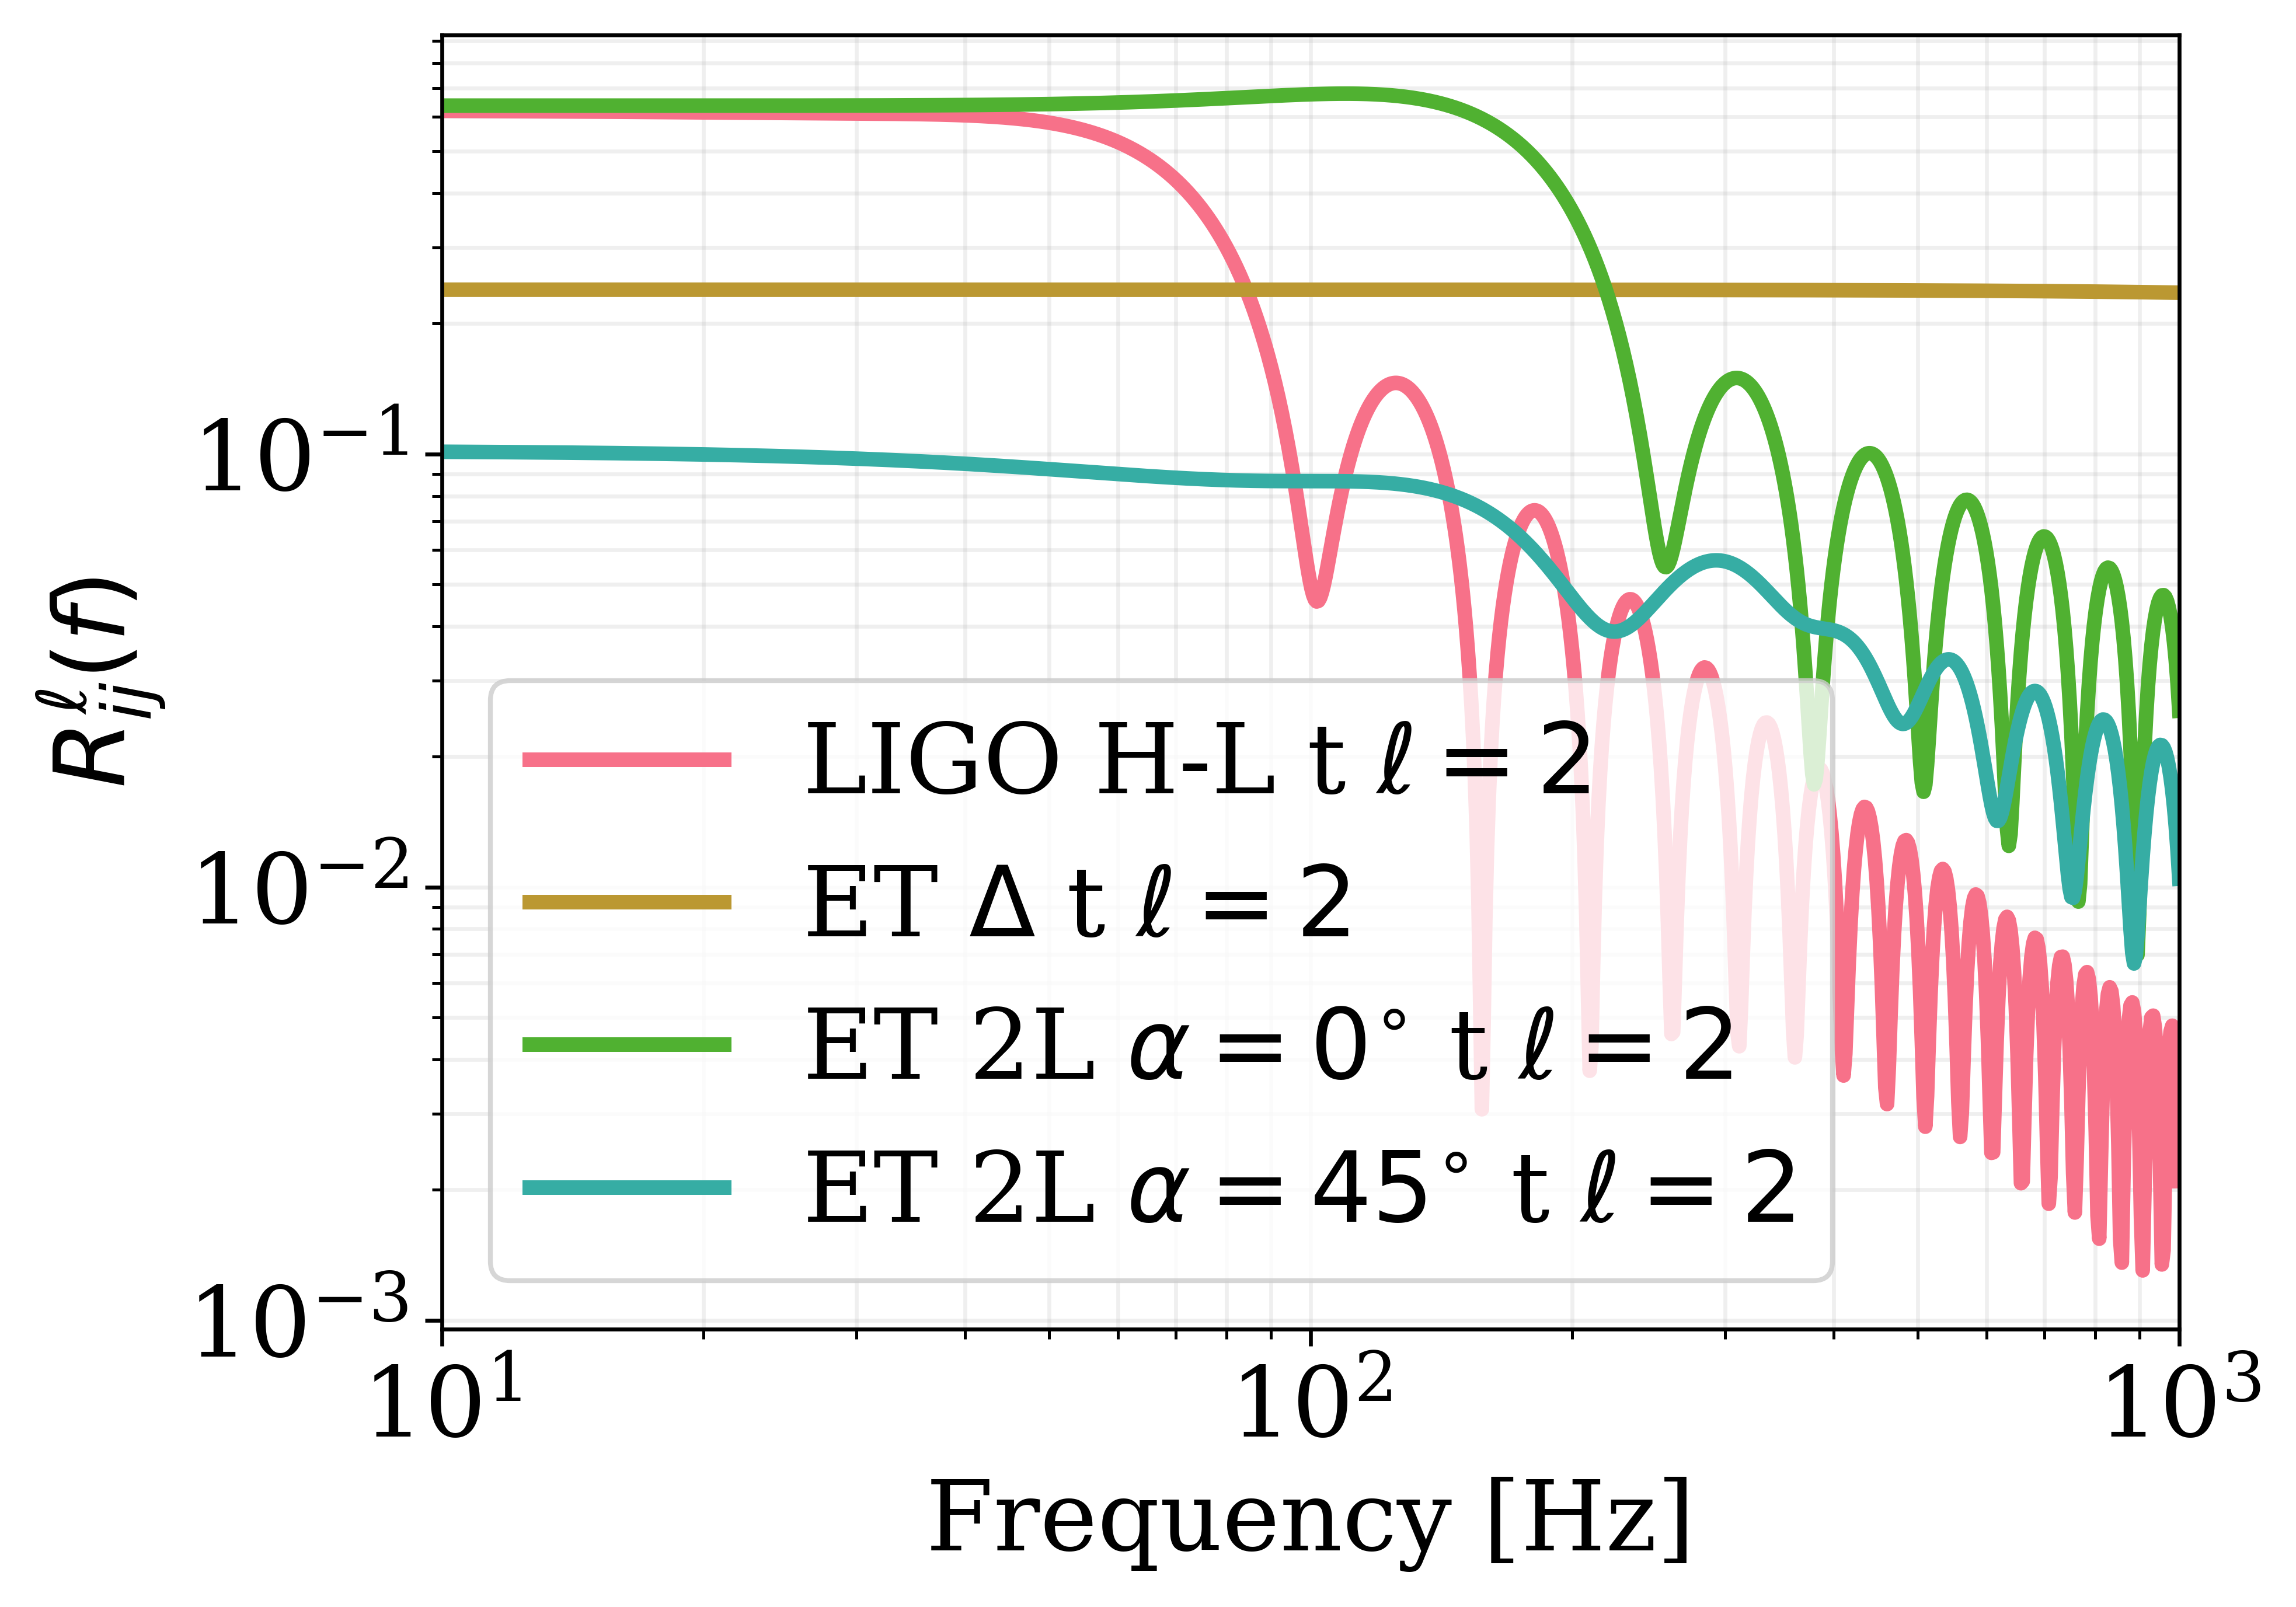

In [43]:
plt.plot(f, R2_LIGO, label=r'LIGO H-L t $\ell=2$')
plt.plot(f, R2_ET, label=r'ET $\Delta$ t $\ell=2$')
plt.plot(f, R2_ET2L0, label=r'ET 2L $\alpha=0^{\circ}$ t $\ell=2$')
plt.plot(f, R2_ET2L45, label=r'ET 2L $\alpha=45^{\circ}$ t $\ell=2$')

plt.xlabel('Frequency [Hz]')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$R_{ij}^{\ell}(f)$')
plt.xlim(f.min(), f.max())
plt.grid(which='both', alpha=0.2)
plt.legend()  


## LISA AET basis

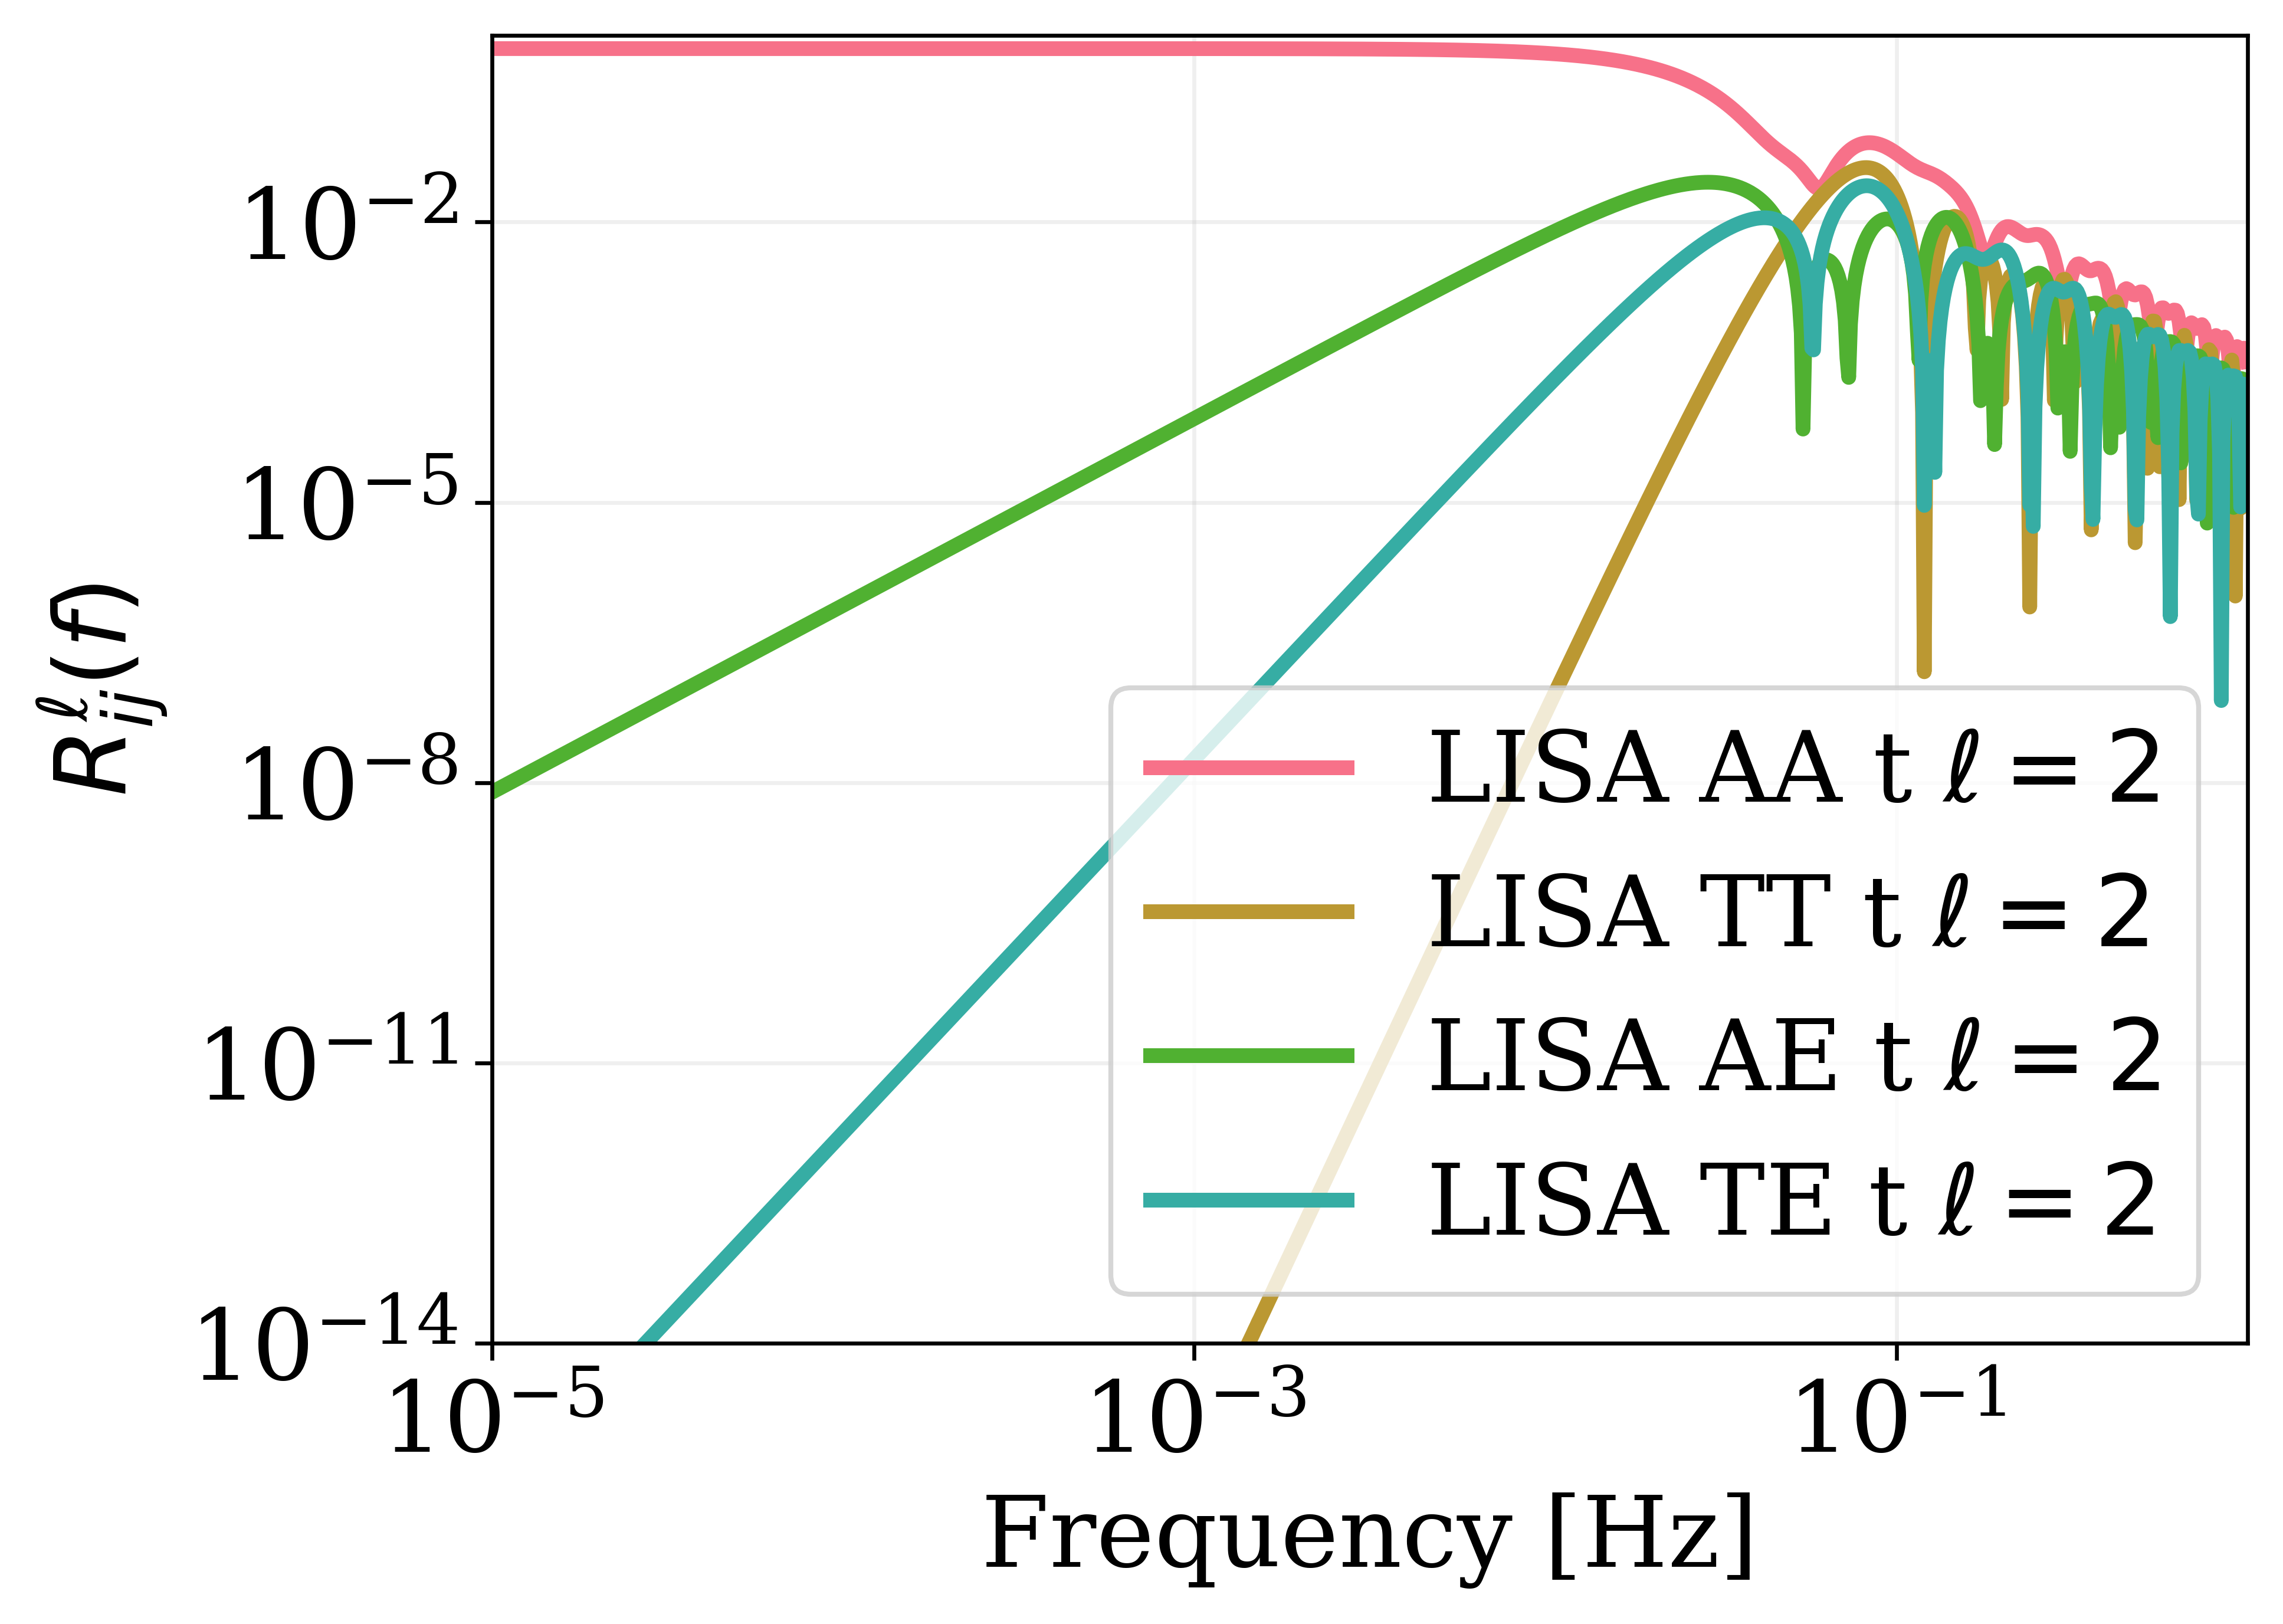

In [44]:
ell = 2
R2_LISA_AA = AngularResponse.R_ell(ell,'LISA A', 'LISA A', f_lisa, 't', 0)
R2_LISA_TT = AngularResponse.R_ell(ell,'LISA T', 'LISA T', f_lisa, 't', 0)
R2_LISA_AE = AngularResponse.R_ell(ell,'LISA A', 'LISA E', f_lisa, 't', 0)
R2_LISA_TE = AngularResponse.R_ell(ell,'LISA E', 'LISA T', f_lisa, 't', 0)


plt.figure()
plt.plot(f_lisa, R2_LISA_AA, label='LISA AA t $\ell=2$')
plt.plot(f_lisa, R2_LISA_TT, label='LISA TT t $\ell=2$')
plt.plot(f_lisa, R2_LISA_AE, label='LISA AE t $\ell=2$')
plt.plot(f_lisa, R2_LISA_TE, label='LISA TE t $\ell=2$')
plt.xlabel('Frequency [Hz]')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$R_{ij}^{\ell}(f)$')
plt.xlim(f_lisa.min(), f_lisa.max())
plt.grid(which='both', alpha=0.2)
plt.ylim(1e-14, 1)
plt.legend()


# Angular Power Law Sensitivity Curve

## Detectors


Evaluate the sensitivity of a couple of detector to a GWB signal for a specific multipole ell.

sens_ell = Sensitivity_ell.PLS_l(det1, det2, Rl, f, fref, snr, Tobs, beta_min, beta_max, Cl, psi, fI=None, PnI=None, fJ=None, PnJ=None)

Parameters:

- det1, det2: str or list of str
    The name of the detector(s) to consider.
    The names must be in the list of detectors available in the response module.
    The list of available detectors can be obtained by calling the function detectors.available_detectors().
    The names of the detectors are case sensitive.
    If you want to provide a custom detector, you can provide the following information in a list:

    H = [c, xA, xB, l, name]

    - c: array_like of length 3 (Position of the detector in the Earth-centered frame in meters)
    - xA: array_like of length 3 (Unit vector pointing towards the detector in the Earth-centered frame)
    - xB: array_like of length 3 (Unit vector pointing towards the detector in the Earth-centered frame)
    - l: float (Length of the arm in meters)
    - name: str (Name of the detector)

- Rl: array_like (Angular response for the multipole ell)
- f = array_like (Frequency in Hz)
- fref = float (Reference frequency in Hz)
- snr = float (Signal-to-noise ratio threshold)
- Tobs = float (Observation time in years)
- beta_min = float (Minimum tilt to consider)
- beta_max = float (Maximum tilt to consider)
- Cl = float (Cl for the multipole ell)
- psi: float (Polarization angle in radians)

Optional parameters:
- fI = bool or array_like (Frequency in Hz for the detector I)
- PnI = bool or array_like (Power spectral density for the detector I)
- fJ = bool or array_like (Frequency in Hz for the detector J)
- PnJ = bool or array_like (Power spectral density for the detector J)

In [45]:
Cl = 1e-3
l=2
Tobs = 1
fref = 10
snr = 1

pls2_LIGO = Sensitivity_ell.PLS_ell('LIGO H', 'LIGO L', l, f, 't', 0, fref, snr, Tobs, Cl)
pls2_ET = Sensitivity_ell.PLS_ell('ET X', 'ET Y', l, f, 't', 0, fref,  snr, Tobs,  Cl)
pls2_ET2L0 = Sensitivity_ell.PLS_ell('ET L1', 'ET L2', l, f, 't', 0,  fref, snr, Tobs, Cl, 0)
pls2_ET2L45 = Sensitivity_ell.PLS_ell('ET L1', 'ET L2', l, f, 't', 0,  fref, snr, Tobs,  Cl, np.pi/4)


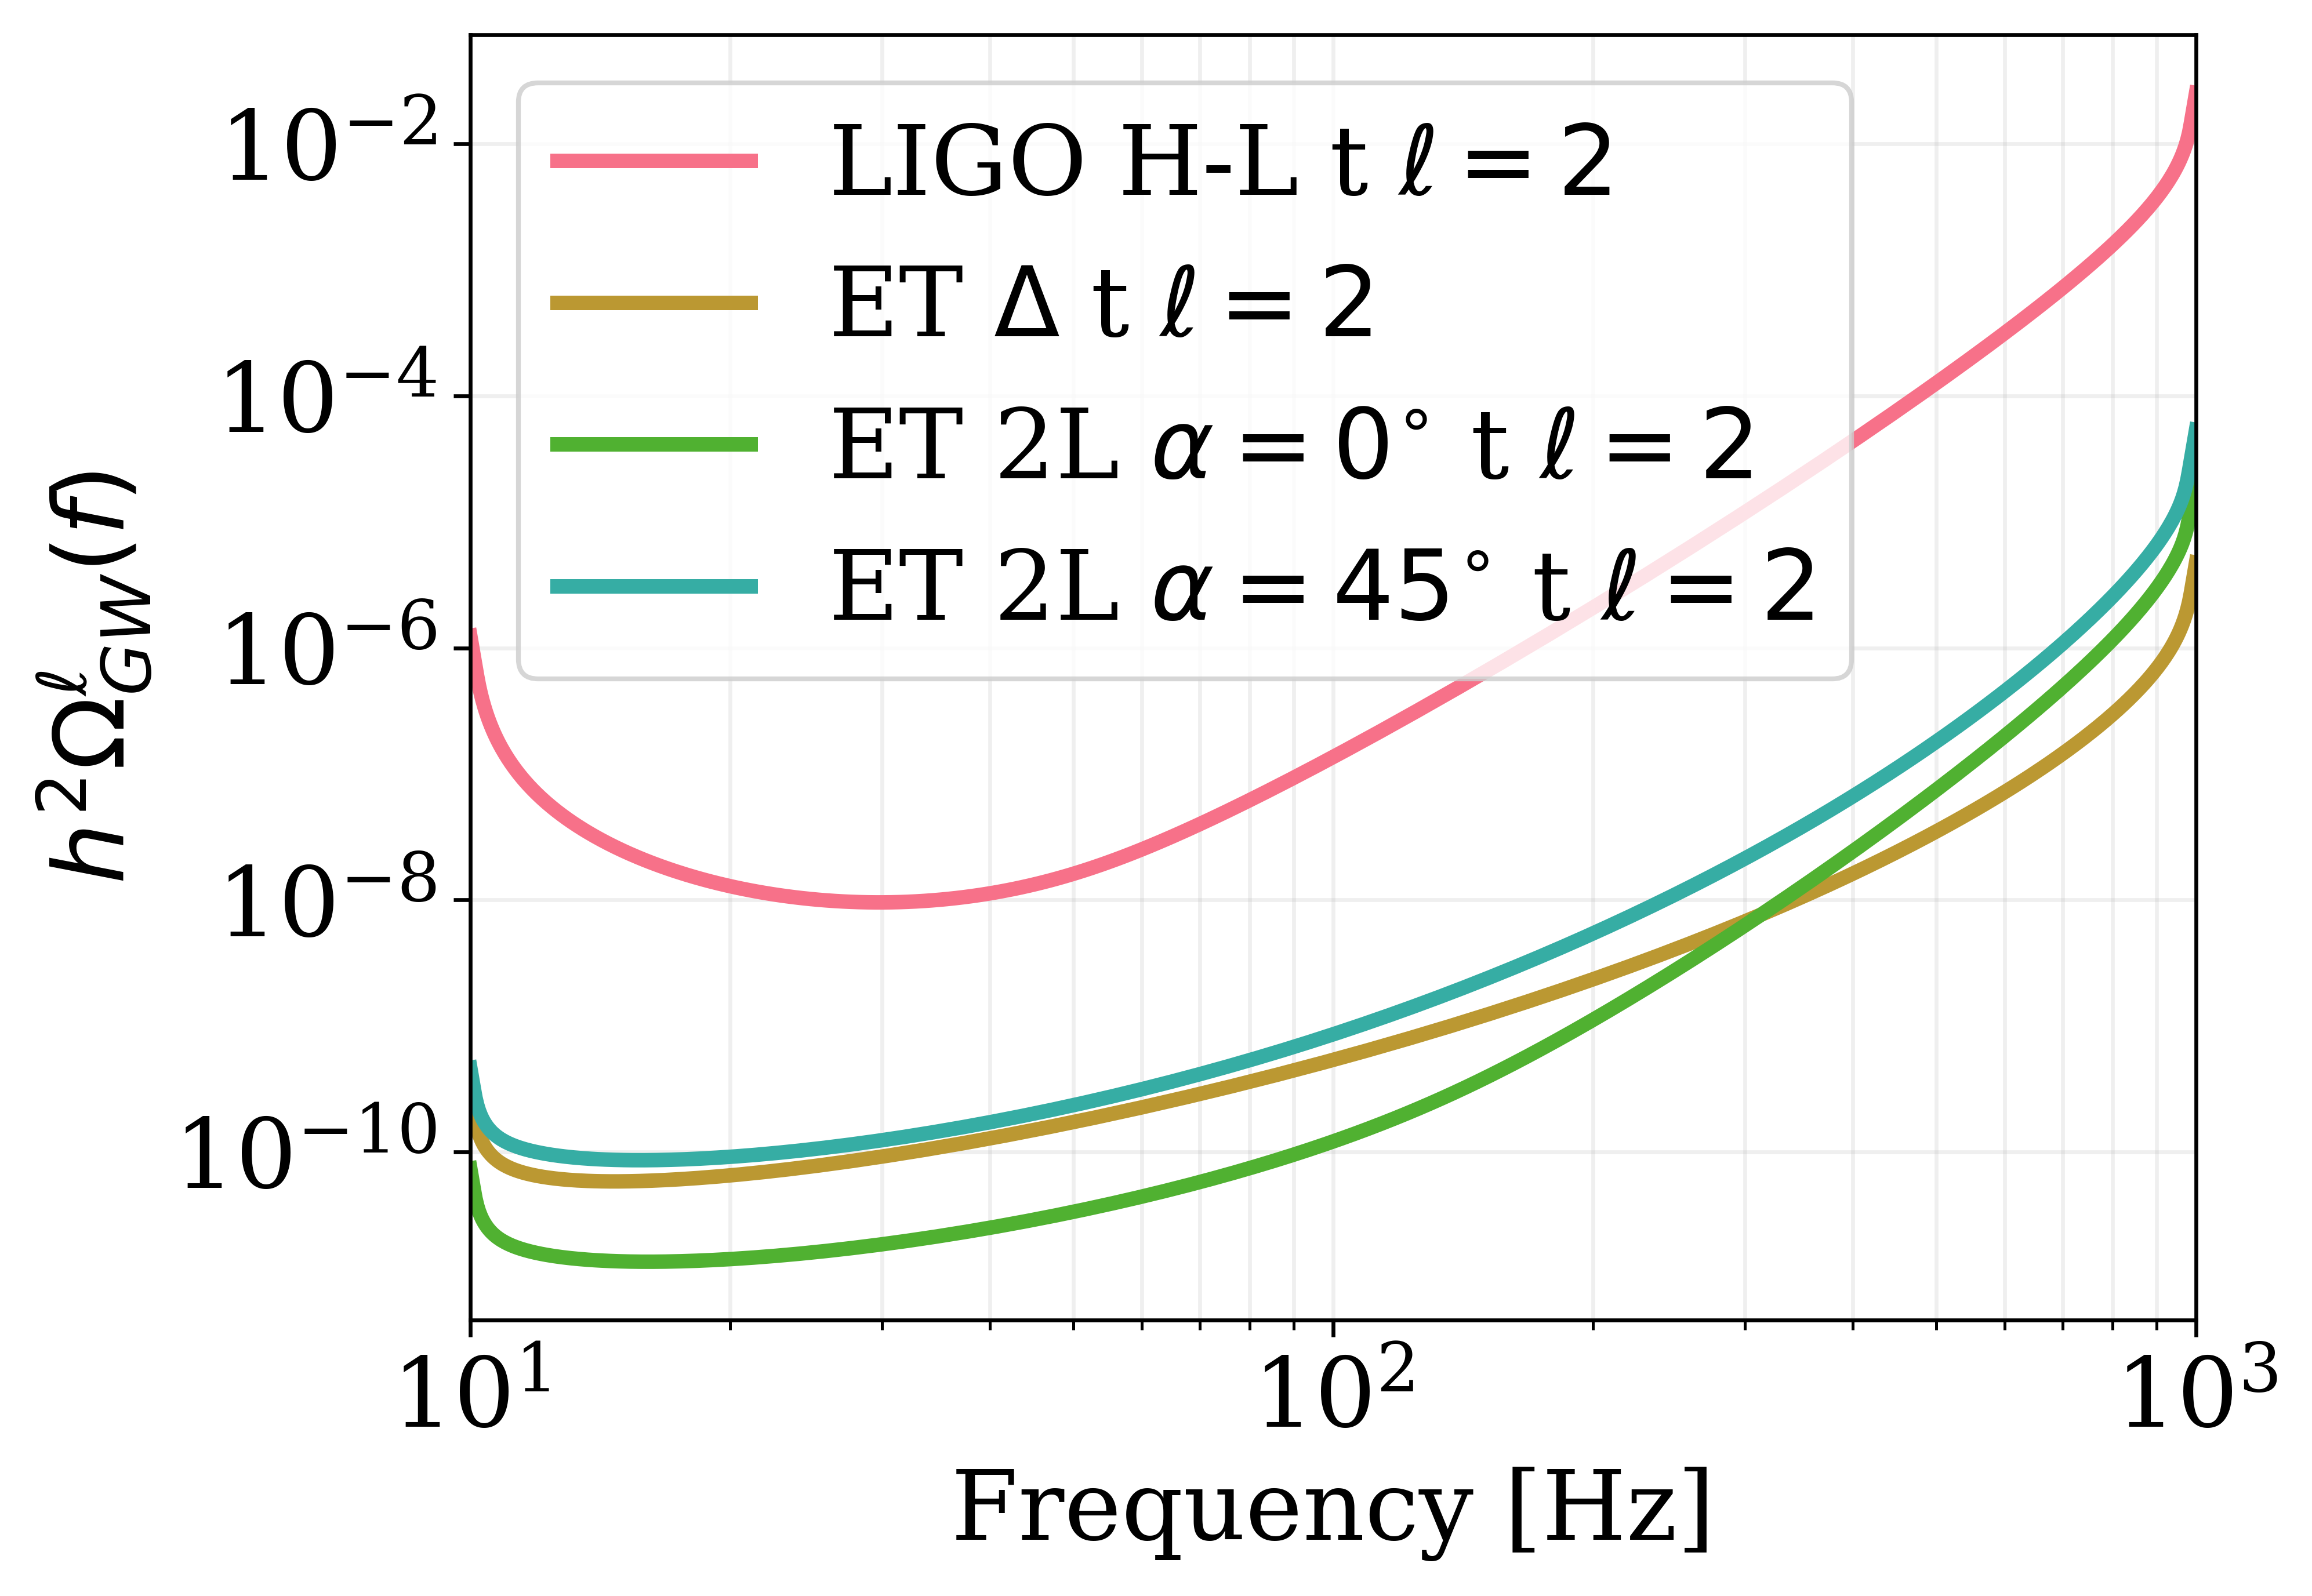

In [46]:
plt.plot(f, pls2_LIGO, label=r'LIGO H-L t $\ell=2$')
plt.plot(f, pls2_ET, label=r'ET $\Delta$ t $\ell=2$')
plt.plot(f, pls2_ET2L0, label=r'ET 2L $\alpha=0^{\circ}$ t $\ell=2$')
plt.plot(f, pls2_ET2L45, label=r'ET 2L $\alpha=45^{\circ}$ t $\ell=2$')
plt.xlabel('Frequency [Hz]')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$h^2 \Omega_{GW}^{\ell}(f)$')
plt.xlim(f.min(), f.max())
plt.grid(which='both', alpha=0.2)
plt.legend()


## LISA

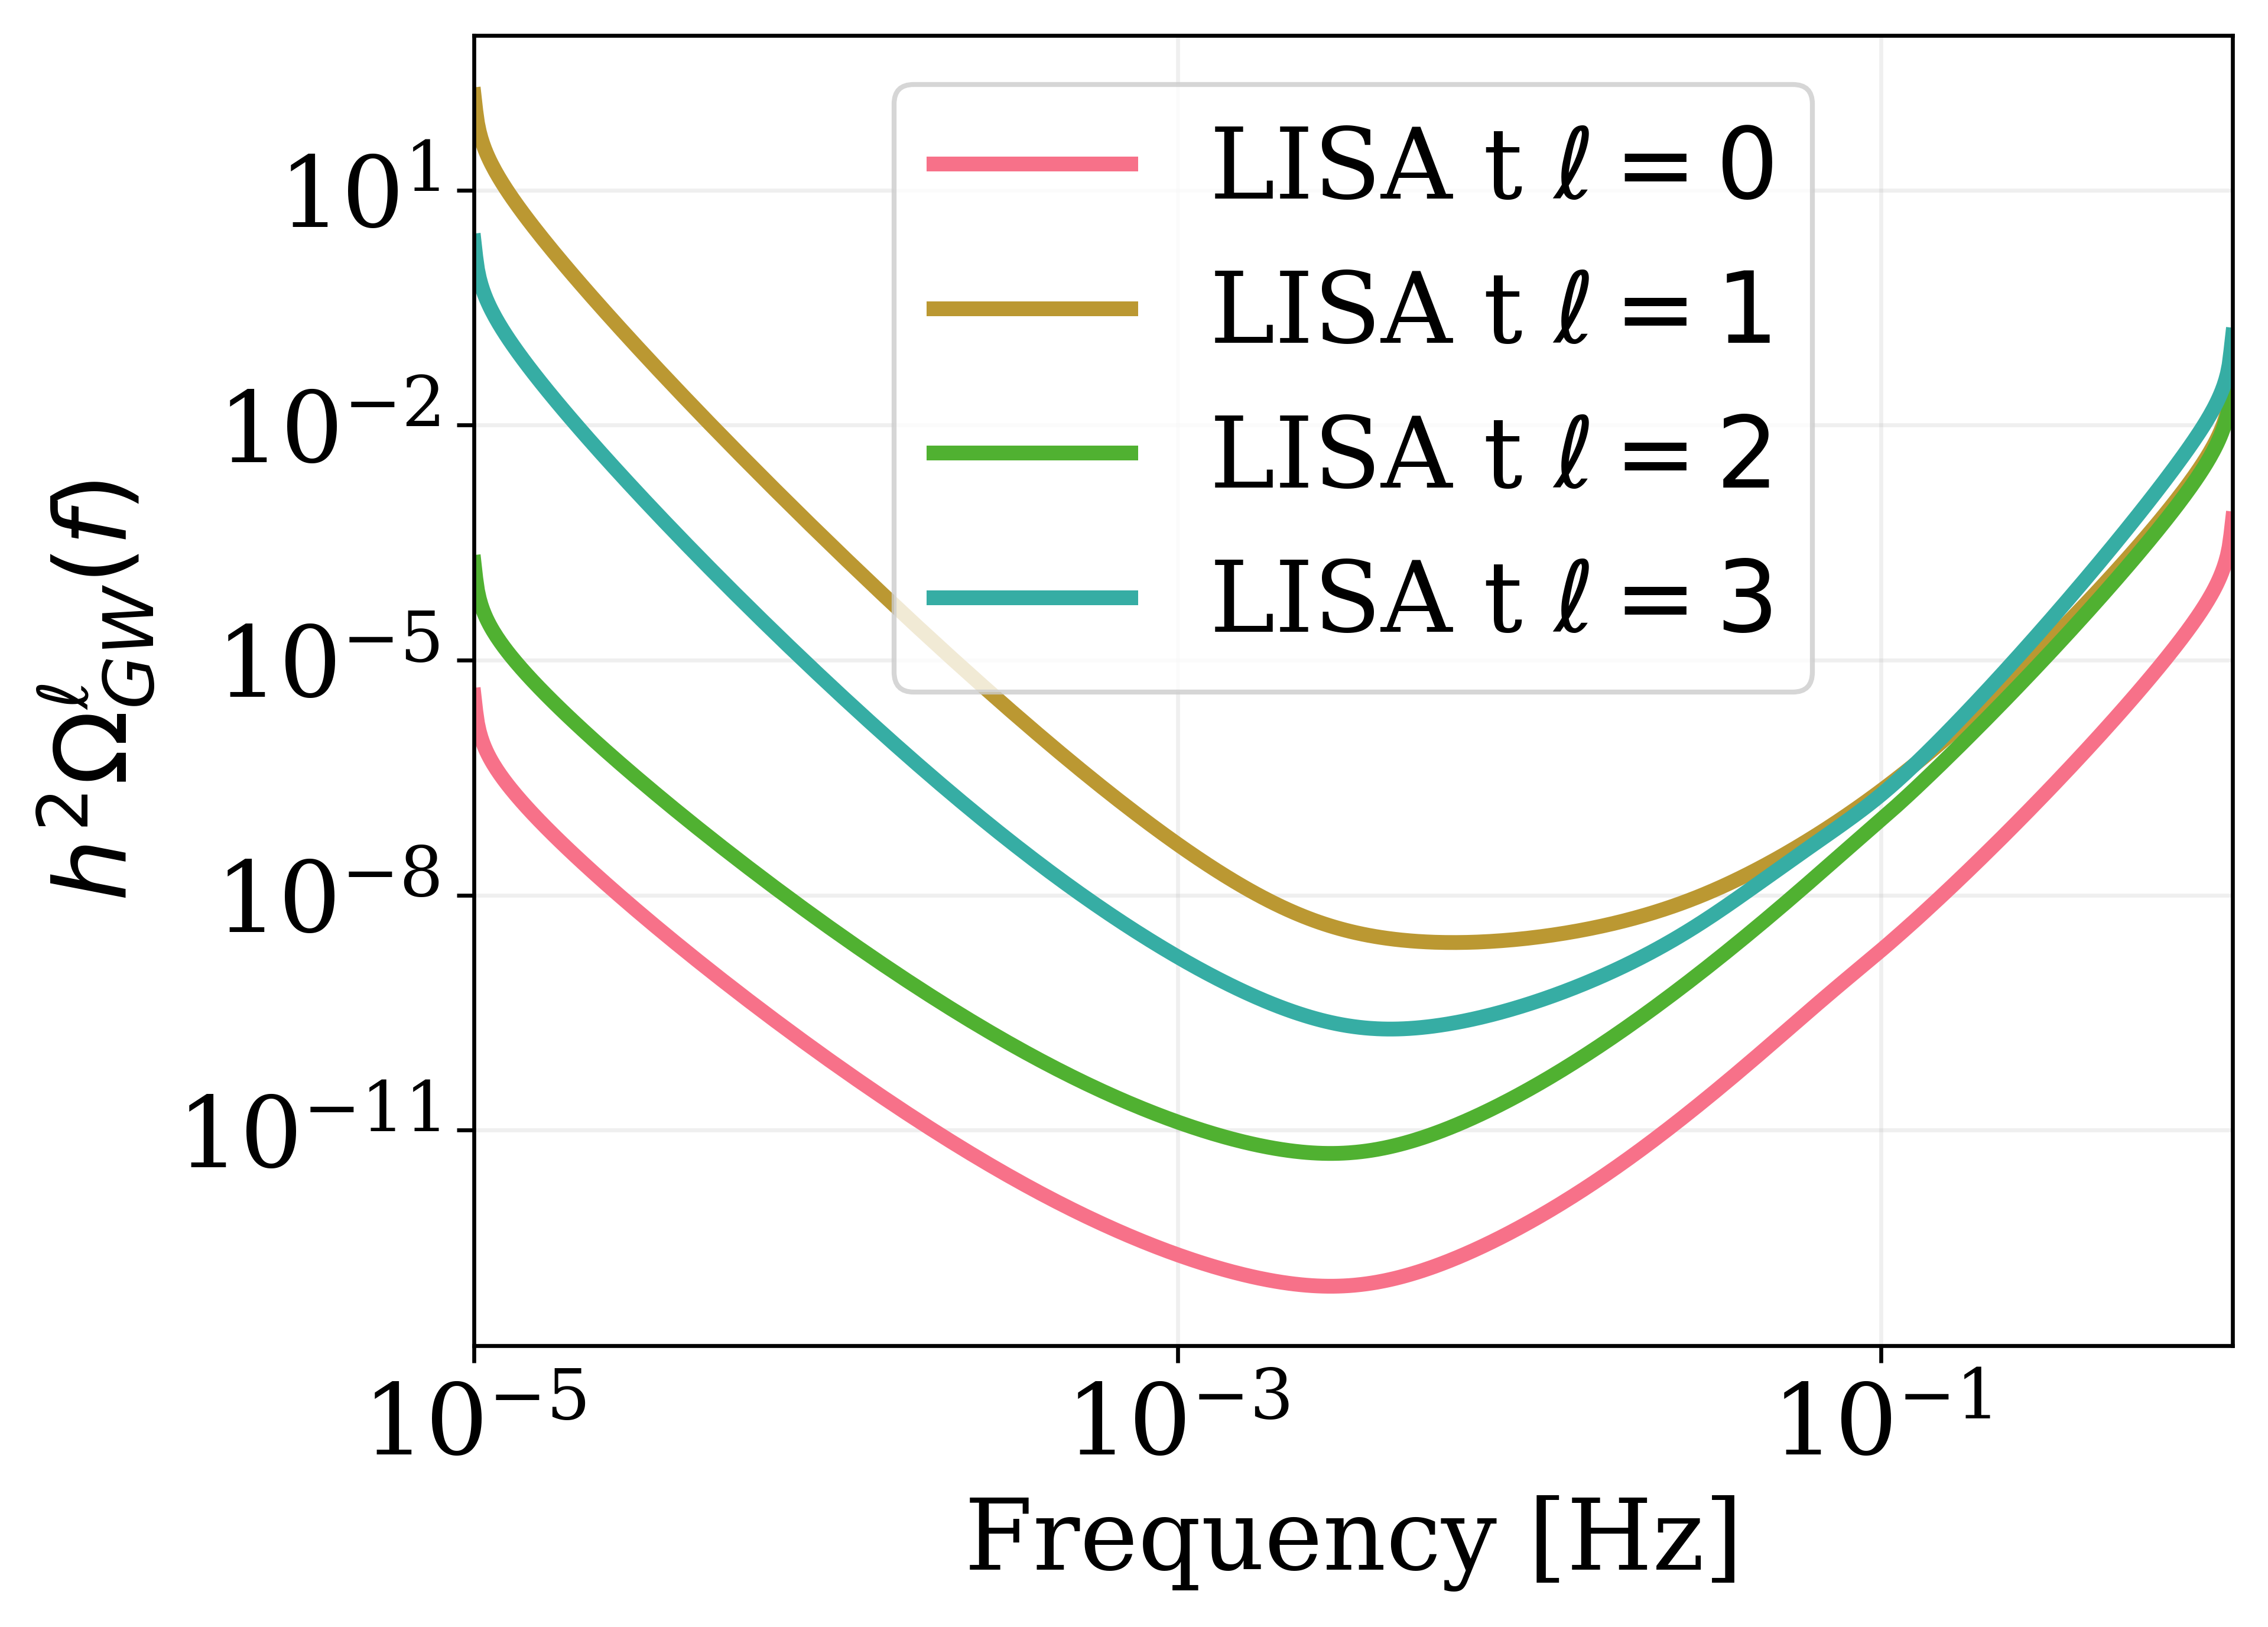

In [47]:
Tobs = 3
snr = 10
pls0_LISA = Sensitivity_ell.PLS_ell('LISA', 'Network', 0, f_lisa, 't', 0, 1e-2, snr, Tobs, 1)
pls1_LISA = Sensitivity_ell.PLS_ell('LISA', 'Network', 1, f_lisa, 't', 0, 1e-2, snr, Tobs, 1e-3)
pls2_LISA = Sensitivity_ell.PLS_ell('LISA', 'Network', 2, f_lisa, 't', 0, 1e-2, snr, Tobs, 1e-3)
pls3_LISA = Sensitivity_ell.PLS_ell('LISA', 'Network', 3, f_lisa, 't', 0, 1e-2, snr, Tobs, 1e-3)

plt.figure()
plt.plot(f_lisa, pls0_LISA, label='LISA t $\ell=0$')
plt.plot(f_lisa, pls1_LISA, label='LISA t $\ell=1$')
plt.plot(f_lisa, pls2_LISA, label='LISA t $\ell=2$')
plt.plot(f_lisa, pls3_LISA, label='LISA t $\ell=3$')
plt.xlabel('Frequency [Hz]')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$h^2 \Omega_{GW}^{\ell}(f)$')
plt.xlim(f_lisa.min(), f_lisa.max())
plt.grid(which='both', alpha=0.2)
plt.legend()



# Pulsar Timing Array

PLS comparison

In [51]:
snr = 1
Tobs = 20
pls_NANOGrav = pls.PLS_PTA_NANOGrav(f, snr, Tobs, 't', psi=0)
pls_EPTA = pls.PLS_PTA_EPTA(f, snr, Tobs, 't', psi=0)

2025-03-07 16:49:24.263 | DEBUG    | pint.models.binary_ddk:validate:210 - Validating DDK model in ECL coordinates


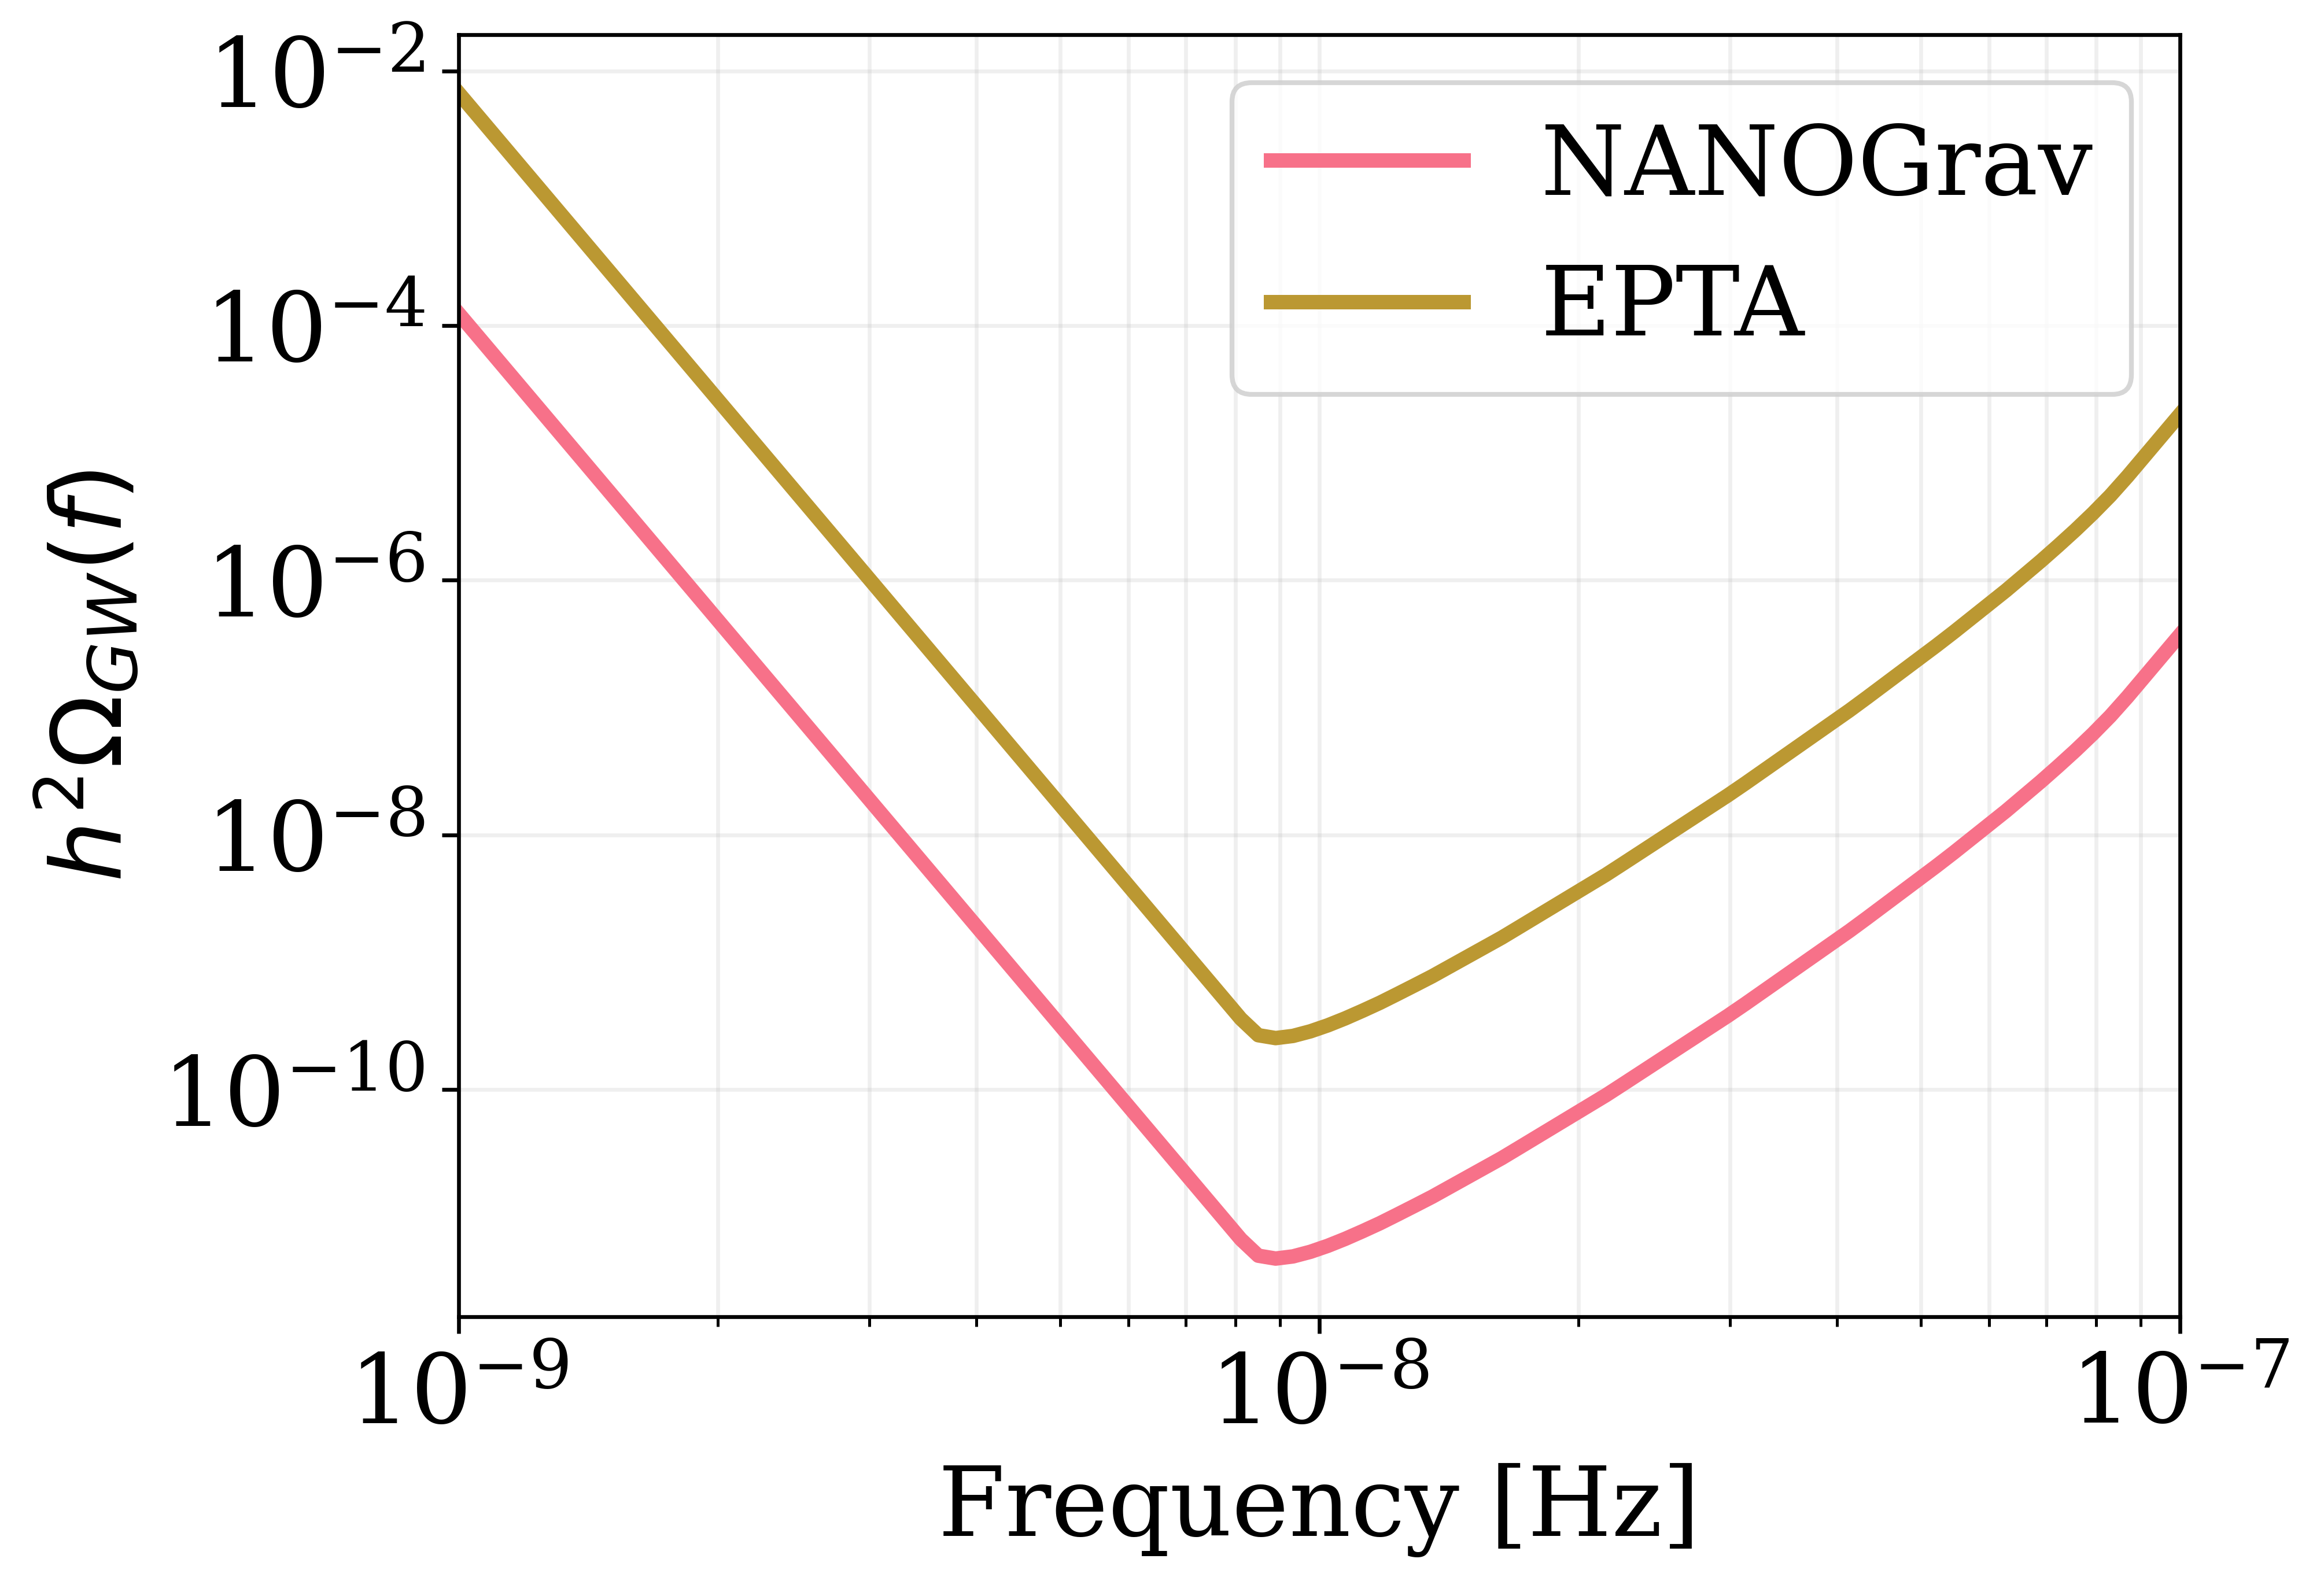

In [52]:
plt.loglog(f, pls_NANOGrav, label='NANOGrav')
plt.loglog(f, pls_EPTA, label='EPTA')
plt.xlabel('Frequency [Hz]')
plt.ylabel(r'$h^2 \Omega_{GW}(f)$')
plt.xlim(f.min(), f.max())
plt.grid(which='both', alpha=0.2)
plt.legend()


Angular PLS

2025-03-07 17:12:18.832 | DEBUG    | pint.models.binary_ddk:validate:210 - Validating DDK model in ECL coordinates
2025-03-07 17:13:20.350 | DEBUG    | pint.models.binary_ddk:validate:210 - Validating DDK model in ECL coordinates


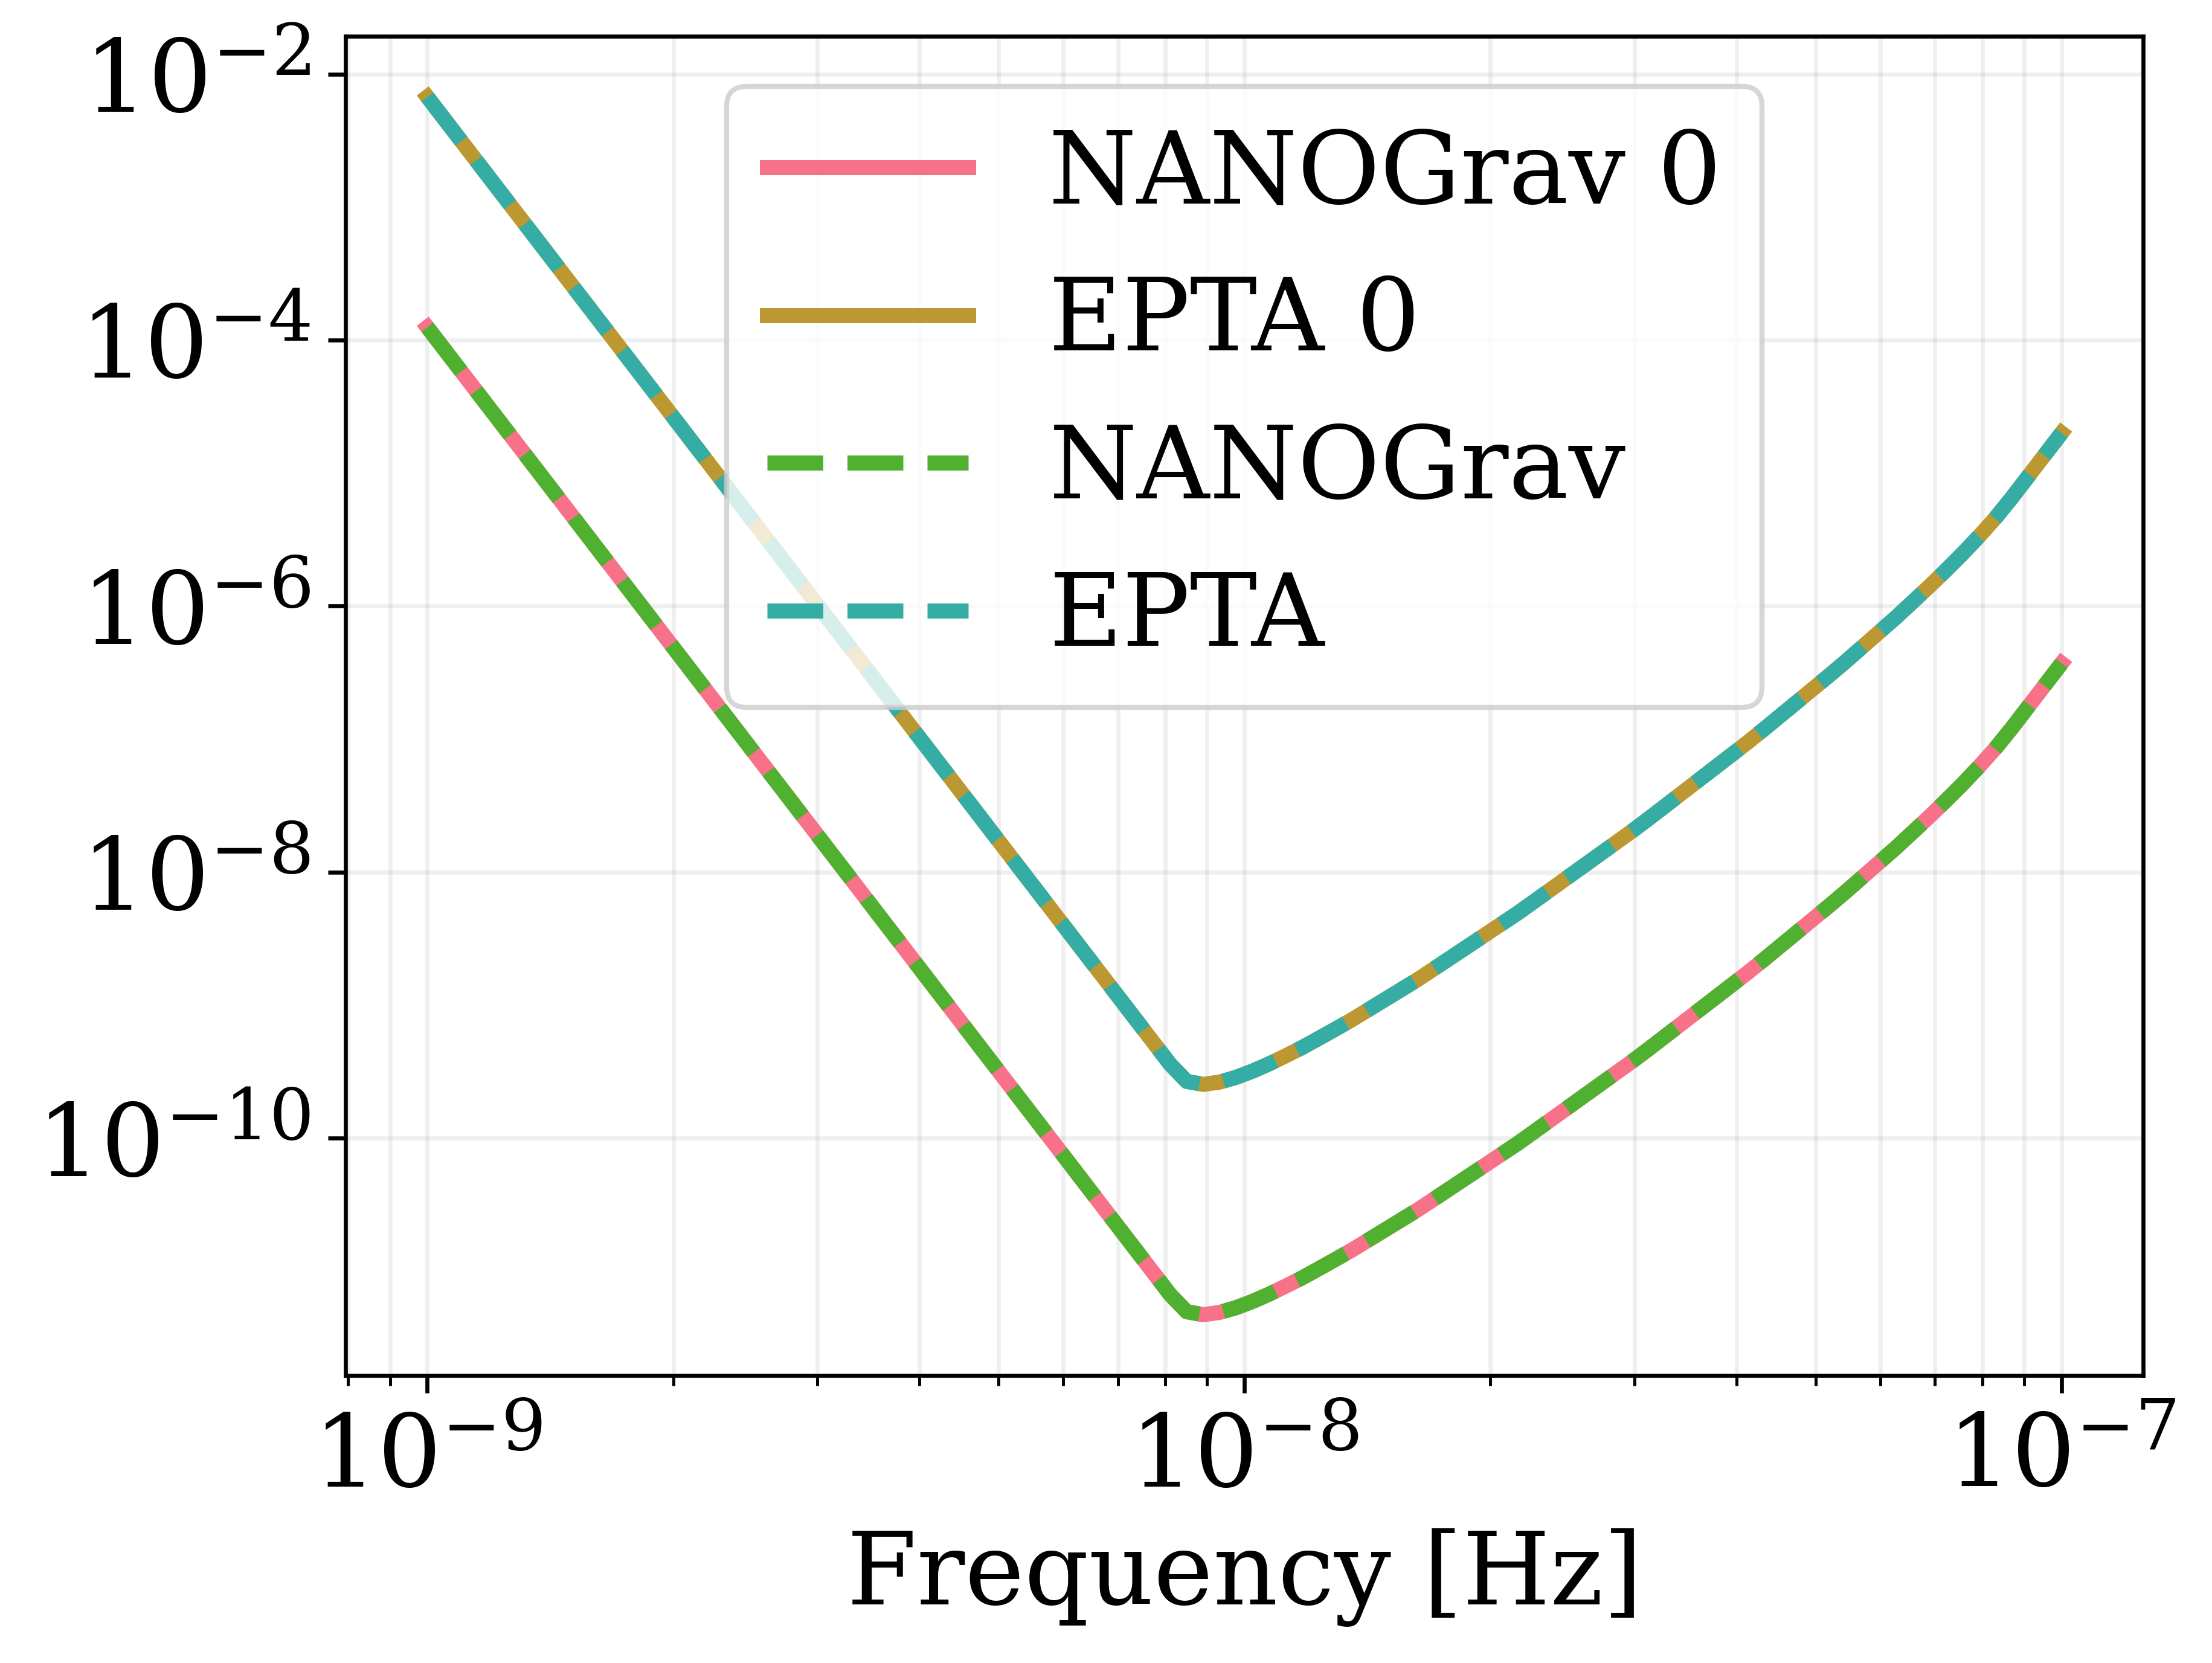

In [59]:
# check with the monopole
f = np.logspace(-9, -7, 100)
snr = 1
Tobs = 20
psi=0

pls_NANOGrav = pls.PLS_PTA_NANOGrav(f, snr, Tobs, 't', psi)
pls_EPTA = pls.PLS_PTA_EPTA(f, snr, Tobs, 't', psi)

pls_NANOGrav_0 = Sensitivity_ell.PLS_ell_PTA_NANOGrav(0, f, snr, Tobs, 1, 't', psi)
pls_EPTA_0 = Sensitivity_ell.PLS_ell_PTA_EPTA(0, f, snr, Tobs, 1, 't', psi)

plt.loglog(f, pls_NANOGrav_0, label='NANOGrav 0')
plt.loglog(f, pls_EPTA_0, label='EPTA 0')
plt.loglog(f, pls_NANOGrav, label='NANOGrav', linestyle='--')
plt.loglog(f, pls_EPTA, label='EPTA', linestyle='--')
plt.xlabel('Frequency [Hz]')
plt.legend()
plt.grid(which='both', alpha=0.2)
plt.show()

In [80]:
f = np.logspace(-9, -7, 100)
snr = 1
Tobs = 20
psi=0

pls_NANOGrav_0 = Sensitivity_ell.PLS_ell_PTA_NANOGrav(0, f, snr, Tobs, 1, 't', psi)
pls_NANOGrav_1 = Sensitivity_ell.PLS_ell_PTA_NANOGrav(1, f, snr, Tobs, 1e-3, 't', psi)
pls_NANOGrav_2 = Sensitivity_ell.PLS_ell_PTA_NANOGrav(2, f, snr, Tobs, 1e-3, 't', psi)
pls_NANOGrav_3 = Sensitivity_ell.PLS_ell_PTA_NANOGrav(3, f, snr, Tobs, 1e-3, 't', psi)

2025-03-08 11:31:14.799 | DEBUG    | pint.models.binary_ddk:validate:210 - Validating DDK model in ECL coordinates
2025-03-08 11:31:45.625 | DEBUG    | pint.models.binary_ddk:validate:210 - Validating DDK model in ECL coordinates
2025-03-08 11:33:05.956 | DEBUG    | pint.models.binary_ddk:validate:210 - Validating DDK model in ECL coordinates
2025-03-08 11:35:15.382 | DEBUG    | pint.models.binary_ddk:validate:210 - Validating DDK model in ECL coordinates


In [83]:
pls_EPTA_0 = Sensitivity_ell.PLS_ell_PTA_EPTA(0, f, snr, Tobs, 1, 't', psi)
pls_EPTA_1 = Sensitivity_ell.PLS_ell_PTA_EPTA(1, f, snr, Tobs, 1e-3, 't', psi)
pls_EPTA_2 = Sensitivity_ell.PLS_ell_PTA_EPTA(2, f, snr, Tobs, 1e-3, 't', psi)
pls_EPTA_3 = Sensitivity_ell.PLS_ell_PTA_EPTA(3, f, snr, Tobs, 1e-3, 't', psi)

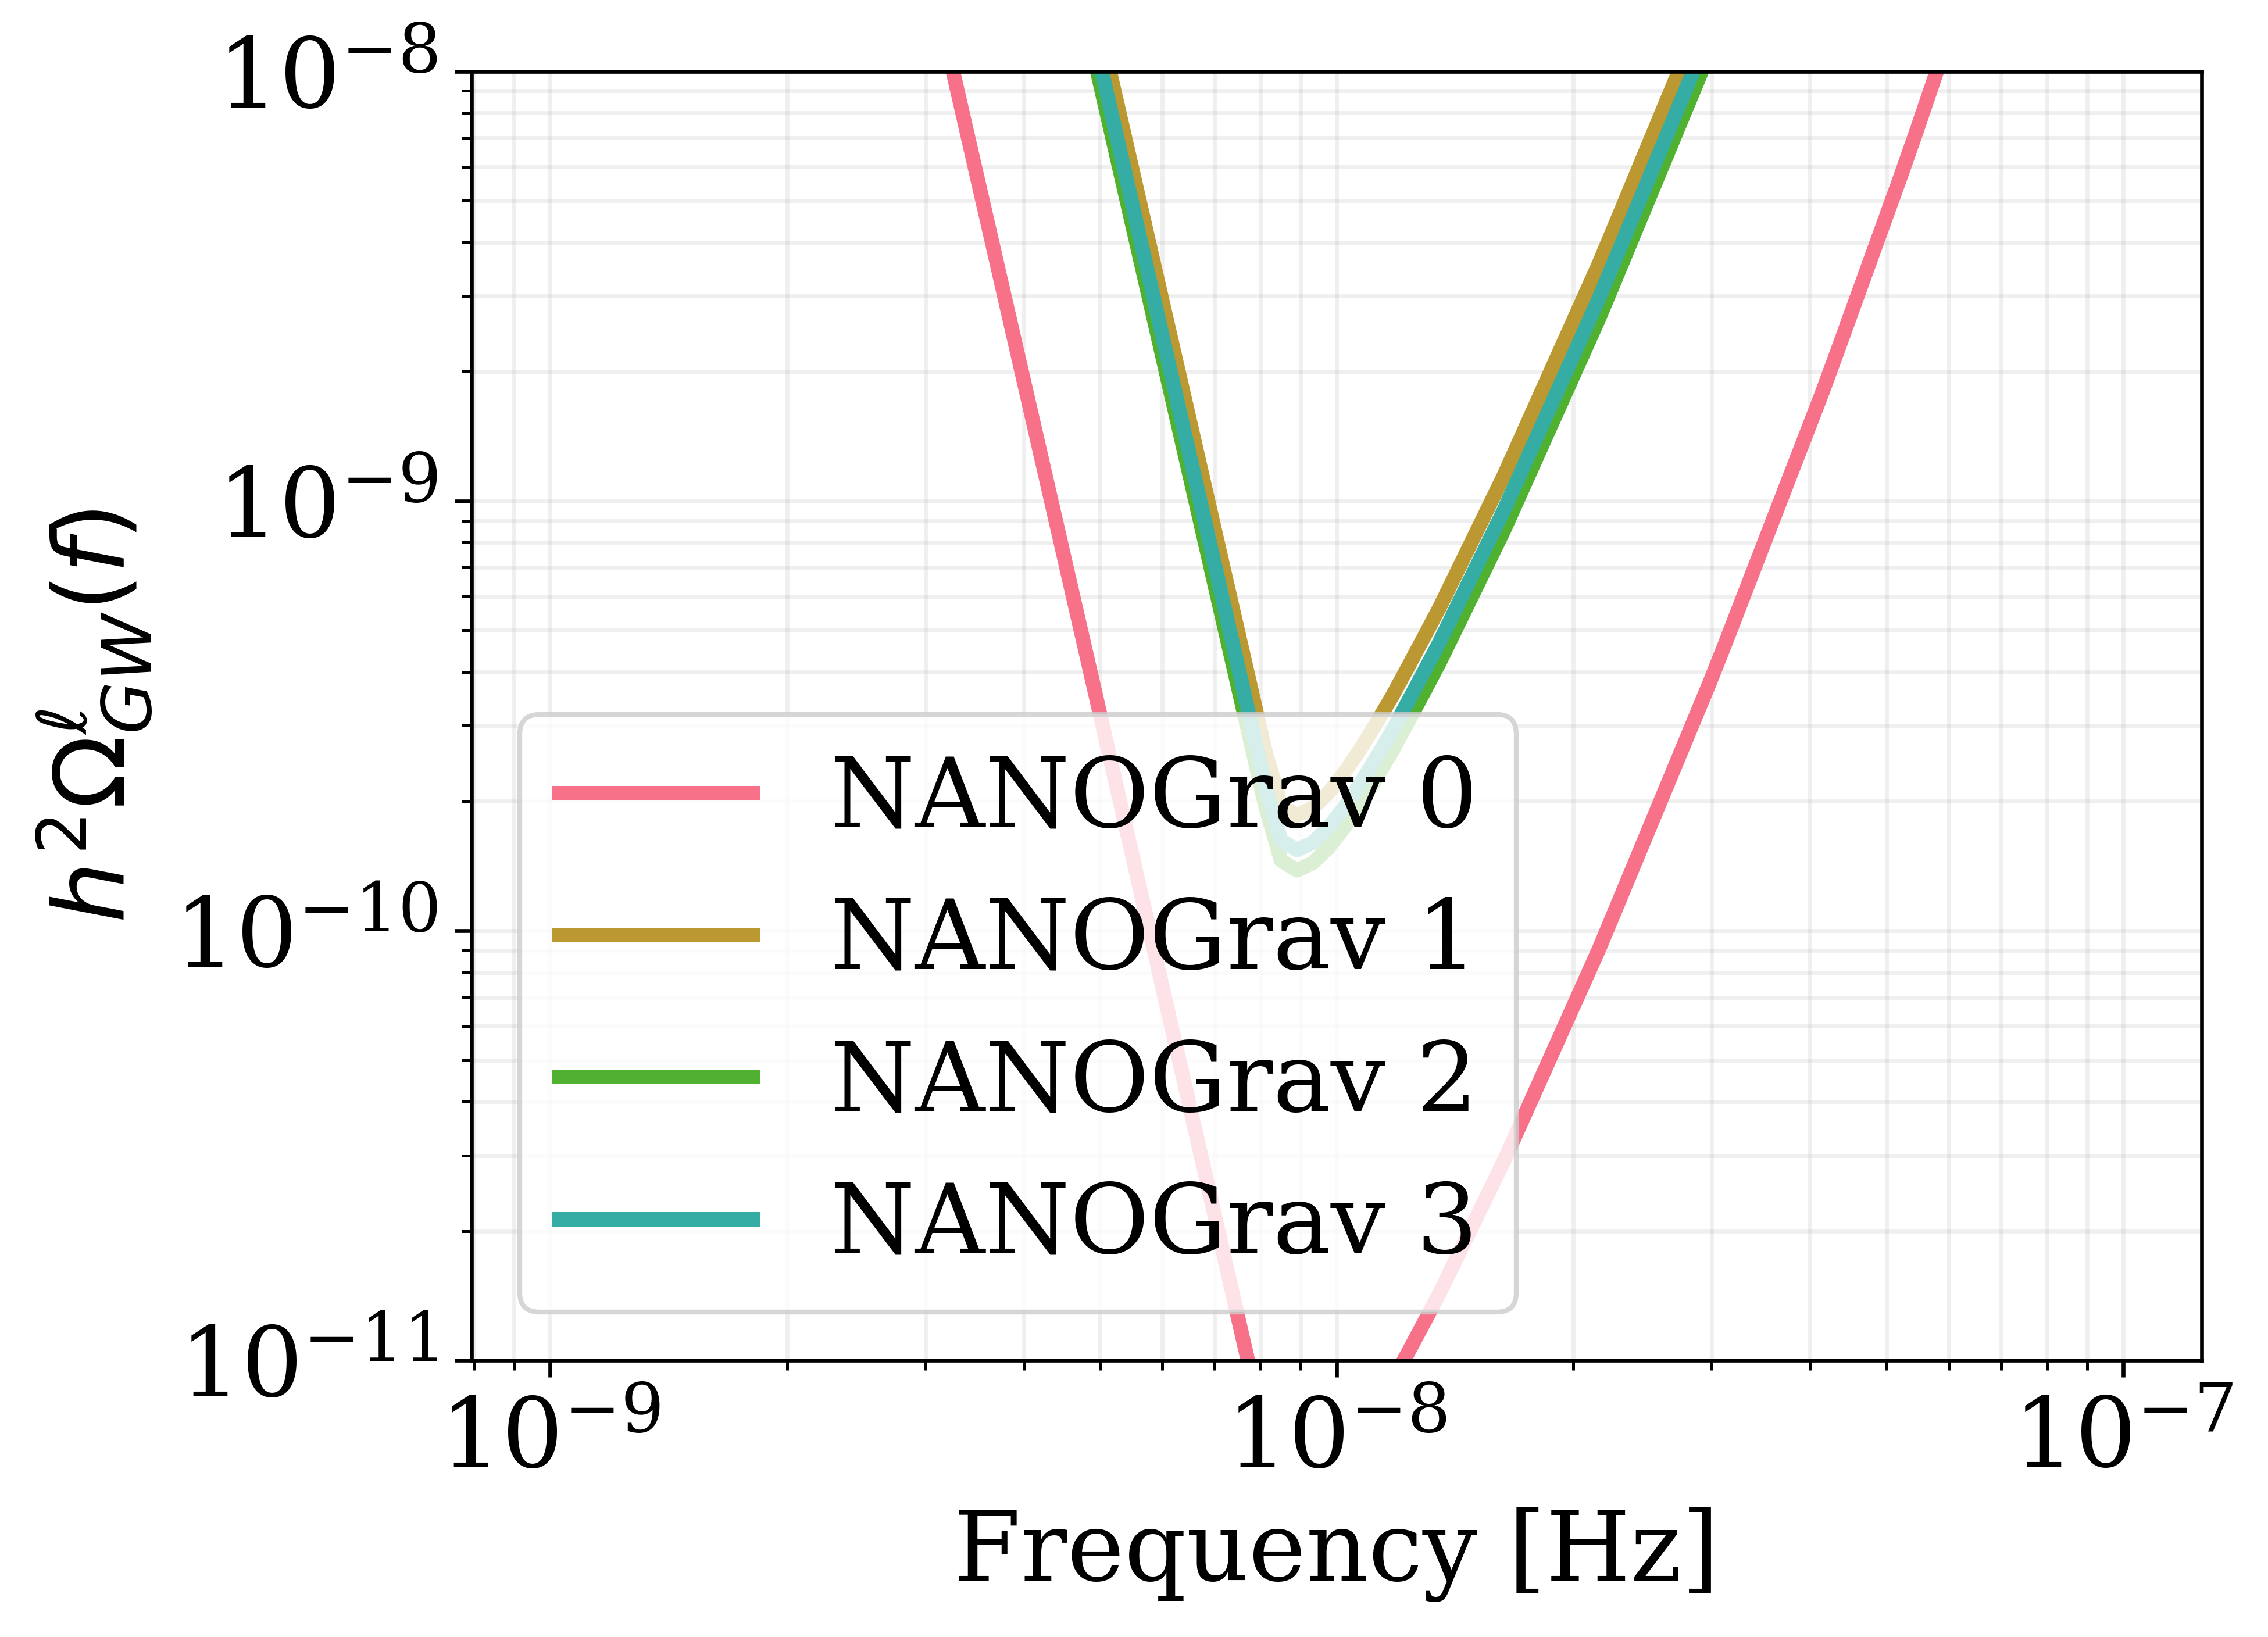

In [81]:

plt.loglog(f, pls_NANOGrav_0, label='NANOGrav 0')
plt.loglog(f, pls_NANOGrav_1, label='NANOGrav 1')
plt.loglog(f, pls_NANOGrav_2, label='NANOGrav 2')
plt.loglog(f, pls_NANOGrav_3, label='NANOGrav 3')
plt.xlabel('Frequency [Hz]')
plt.ylabel(r'$h^2 \Omega_{GW}^{\ell}(f)$')
plt.ylim(1e-11, 1e-8)
plt.legend()
plt.grid(which='both', alpha=0.2)



In [82]:
print(np.min(pls_NANOGrav_0))
print(np.min(pls_NANOGrav_1))
print(np.min(pls_NANOGrav_2))
print(np.min(pls_NANOGrav_3))

4.709386762207409e-12
1.8546275425148663e-10
1.3824626185283104e-10
1.54108345424761e-10


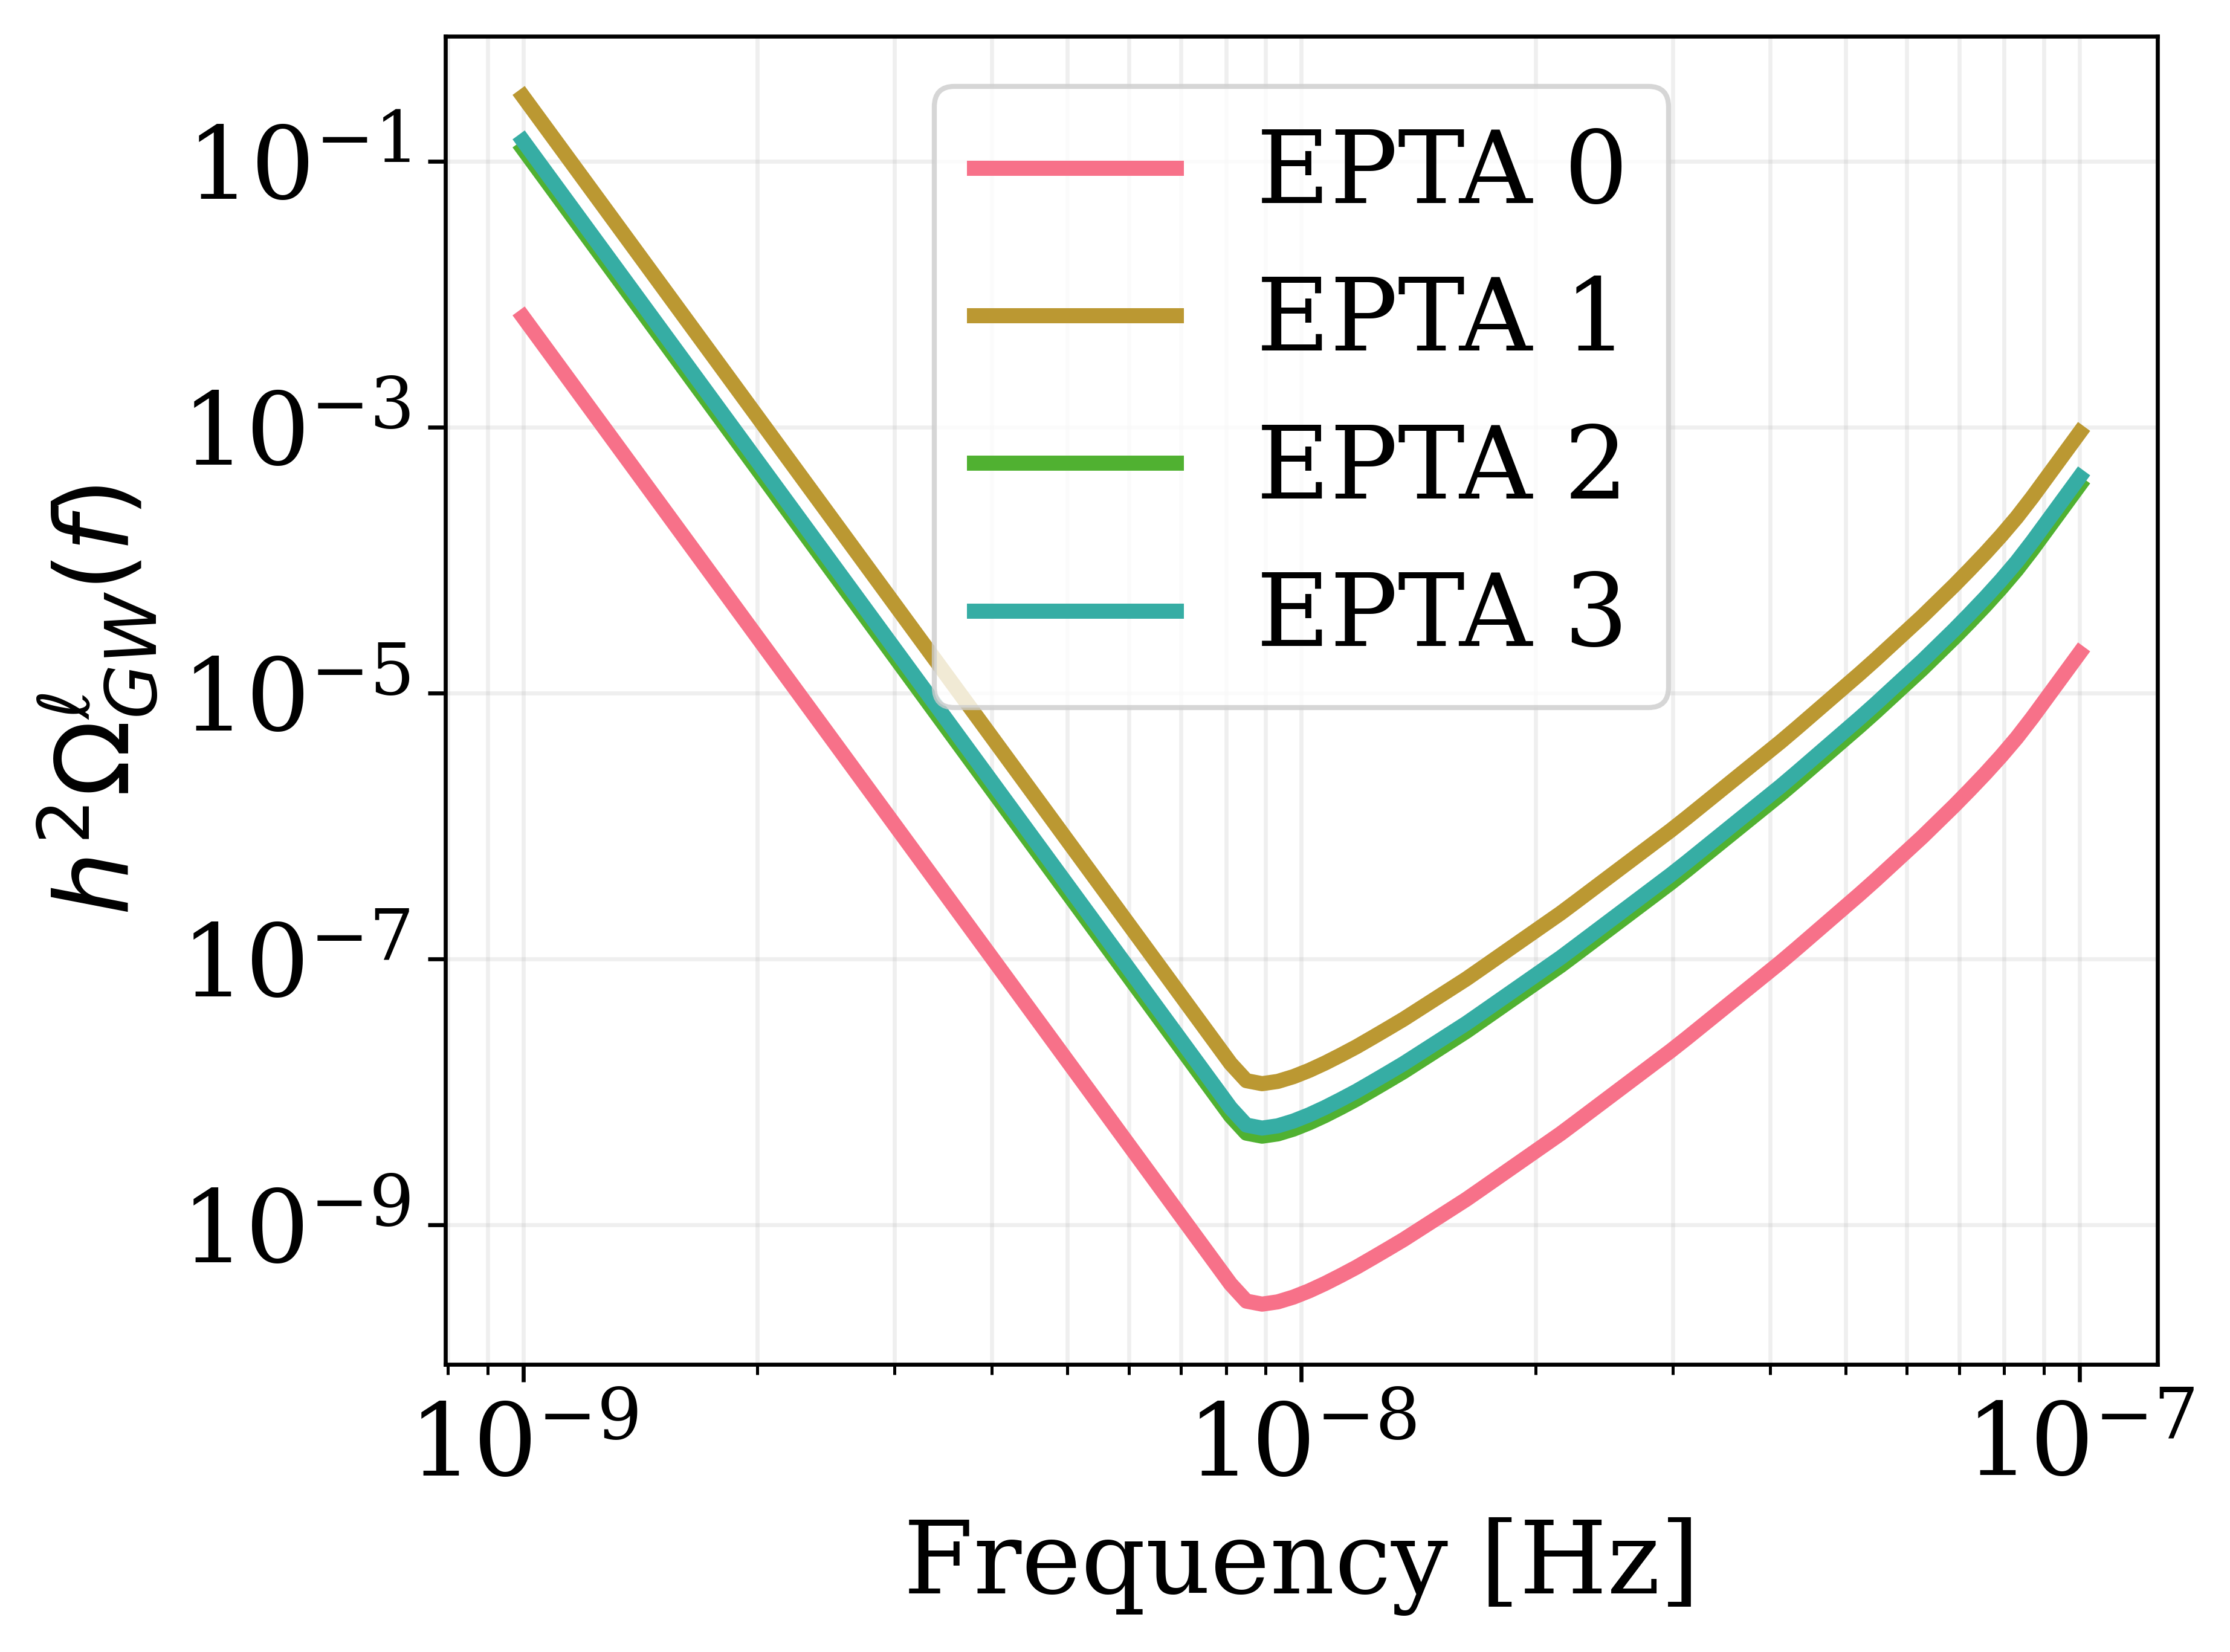

In [85]:

plt.loglog(f, pls_EPTA_0, label='EPTA 0')
plt.loglog(f, pls_EPTA_1, label='EPTA 1')
plt.loglog(f, pls_EPTA_2, label='EPTA 2')
plt.loglog(f, pls_EPTA_3, label='EPTA 3')
plt.xlabel('Frequency [Hz]')
plt.ylabel(r'$h^2 \Omega_{GW}^{\ell}(f)$')

plt.legend()
plt.grid(which='both', alpha=0.2)
plt.tight_layout()
plt.show()